<a href="https://colab.research.google.com/github/polinasvp/-GoFast-Analysis-of-the-GoFast-scooter-rental-service/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5%2C_%D0%A1%D1%83%D1%80%D0%BE%D0%B2%D0%B0_%D0%9F%D0%BE%D0%BB%D0%B8%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ HR-данных компании

---


Цель: Провести комплексный анализ сотрудников компании для оценки организационного здоровья, выявления факторов текучести персонала и оптимизации управления трудовыми ресурсами.

Задачи:

1.	Как оценить общее «здоровье» компании?

2.	Каков текущий уровень текучести персонала?

3.	Можно ли выделить факторы, связанные с текучестью?

4.	Что можно сказать о распределении фонда оплаты труда (ФОТ)?

5.	Какие факторы влияют на эффективность сотрудников `Performance Score`?

6.	Предложи модель прогноза увольнения сотрудников.

7.	Оцени потенциальный эффект.

Представь, что в прошлом году в одном из департаментов было внедрено новое обучение/подход к управлению. Придумай, как можно оценить эффективность этой меры. Смоделируй на данных используя техники генерации данных и элементы casual inference.

8.	Какие ограничения есть у твоих данных? Какие выводы ты не стал бы делать? Как избежать ошибочной интерпретации результатов? (Рассуждения).



# План работы по проекту


---


### 0. Подготовка данных

* **Загрузка** датасета.
* **Обзор данных**.
* **Проверка и чистка**:

  * Удалить дубликаты.
  * Обработка пропусков:
* **Форматирование**:

  * привести даты к `datetime`,
  * категориальные признаки к `category`,
  * числовые — к `float`/`int`.
* **Базовый EDA**: гистограммы, boxplots, распределения, поиск выбросов.

### 1. Оценка «здоровья» компании

* Собрать ключевые HR-метрики: численность, текучесть, стаж, возраст, найм, ФОТ, больничные/прогулы, `Performance Score`.
* Построить дашборд с базовыми показателями и трендами.
* Проверить наличие перекосов (по полу, возрасту, отделам).

### 2. Уровень текучести персонала

* Рассчитать **annual attrition rate** = уволенные / среднесписочная численность.
* Посчитать помесячно, по подразделениям.
* Визуализировать динамику.

### 3. Факторы текучести

* Построить сводные таблицы по ключевым признакам (возраст, стаж, уровень зарплаты, отдел).
* Применить статистические тесты.
* Запустить логистическую регрессию с меткой «уволился/остался».

### 4. Распределение ФОТ

* Построить распределение зарплат: boxplot/ по отделам.
* Проверить медиану, перцентили, вариацию.
* Сравнить долю ФОТ на разные категории сотрудников.

### 5. Факторы эффективности (`Performance Score`)

* Корреляционный анализ между `Performance Score` и факторами (зарплата, стаж, обучение, департамент).
* Модель регрессии или классификации.
* Feature importance для интерпретации.

### 6. Прогноз увольнения сотрудников

* Подготовить бинарную метку `Attrition = {1: уволился, 0: остался}`.
* Разбить данные на train/test.
* Построить модель: логистическая регрессия, RandomForest, CatBoost.
* Метрики качества: ROC-AUC, Precision, Recall.

### 7. Оценка потенциального эффекта

* Что будет, если снизим текучесть на X%? → рассчитать экономию затрат на найм и адаптацию.
* Если повысим `Performance Score` → оценить вклад в KPI (например, производительность, продажи).
* Смоделировать «что если» сценарии.

### 8. Эффективность нового обучения / управления (causal inference)

* Сгенерировать экспериментальные данные: отдел с обучением (treatment) и отделбез (control).
* Использовать методы:

  * **До-после сравнение** (difference in differences).
  * **Propensity Score Matching** (сопоставление сотрудников по признакам).
* Проверить разницу в `Performance Score` / текучести между группами.

### 9. Ограничения и интерпретация

Мои рассуждения.

# Сбор и подготовка датасета.

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

path = kagglehub.dataset_download("rhuebner/human-resources-data-set")

print("Путь к файлам датасета:", path)

Путь к файлам датасета: /kaggle/input/human-resources-data-set


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [4]:
df = pd.read_csv(f"{path}/HRDataset_v14.csv")
print(df.shape)
df.head()

(311, 36)


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [5]:
# общая информация
print("размер:", df.shape)
print("\nобщая инфа:")
print(df.info())
print("\nописательная статистика (числовые признаки):")
print(df.describe().T)

размер: (311, 36)

общая инфа:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               311 non-null    object 
 1   EmpID                       311 non-null    int64  
 2   MarriedID                   311 non-null    int64  
 3   MaritalStatusID             311 non-null    int64  
 4   GenderID                    311 non-null    int64  
 5   EmpStatusID                 311 non-null    int64  
 6   DeptID                      311 non-null    int64  
 7   PerfScoreID                 311 non-null    int64  
 8   FromDiversityJobFairID      311 non-null    int64  
 9   Salary                      311 non-null    int64  
 10  Termd                       311 non-null    int64  
 11  PositionID                  311 non-null    int64  
 12  Position                    311 non-null    object 
 13  Stat

In [6]:
dup_count = df.duplicated().sum()
print(f"\nдубликатов: {dup_count}")
if dup_count > 0:
    df = df.drop_duplicates()


дубликатов: 0


In [7]:
missing = df.isna().sum()
print("\nпропуски по колонкам:")
print(missing[missing > 0])


пропуски по колонкам:
DateofTermination    207
ManagerID              8
dtype: int64


In [8]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
if "LastPerformanceReview_Date" in df.columns:
    df["LastPerformanceReview_Date"] = pd.to_datetime(
        df["LastPerformanceReview_Date"], errors="coerce"
    )

In [10]:
cat_candidates = ["Department", "Position", "RecruitmentSource",
                  "ManagerName", "PerformanceScore"]
for col in cat_candidates:
    if col in df.columns:
        df[col] = df[col].astype("category")

In [11]:
print("\nпосле обработки:")
print(df.info())


после обработки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Employee_Name               311 non-null    object        
 1   EmpID                       311 non-null    int64         
 2   MarriedID                   311 non-null    int64         
 3   MaritalStatusID             311 non-null    int64         
 4   GenderID                    311 non-null    int64         
 5   EmpStatusID                 311 non-null    int64         
 6   DeptID                      311 non-null    int64         
 7   PerfScoreID                 311 non-null    int64         
 8   FromDiversityJobFairID      311 non-null    int64         
 9   Salary                      311 non-null    int64         
 10  Termd                       311 non-null    int64         
 11  PositionID                  311 non-null

In [12]:
# переведем на русский язык для удобства
rename_dict = {
    "Employee_Name": "Сотрудник",
    "EmpID": "ID",
    "MarriedID": "В_браке_ID",
    "MaritalStatusID": "Семейный_статус_ID",
    "GenderID": "Пол_ID",
    "EmpStatusID": "Статус_работы_ID",
    "DeptID": "Департамент_ID",
    "PerfScoreID": "Оценка_ID",
    "FromDiversityJobFairID": "С_ярмарки_вакансий",
    "Salary": "Оклад",
    "Termd": "Уволен",
    "PositionID": "Должность_ID",
    "Position": "Должность",
    "State": "Штат",
    "Zip": "Почтовый_индекс",
    "DOB": "Дата_рождения",
    "Sex": "Пол",
    "MaritalDesc": "Семейное_положение",
    "CitizenDesc": "Гражданство",
    "HispanicLatino": "Латиноамериканец",
    "RaceDesc": "Раса",
    "DateofHire": "Дата_найма",
    "DateofTermination": "Дата_увольнения",
    "TermReason": "Причина_увольнения",
    "EmploymentStatus": "Статус_занятости",
    "Department": "Департамент",
    "ManagerName": "Менеджер",
    "ManagerID": "Менеджер_ID",
    "RecruitmentSource": "Источник_найма",
    "PerformanceScore": "Оценка",
    "EngagementSurvey": "Вовлеченность",
    "EmpSatisfaction": "Удовлетворенность",
    "SpecialProjectsCount": "Проекты",
    "LastPerformanceReview_Date": "Последняя_оценка",
    "DaysLateLast30": "Опоздания_30дн",
    "Absences": "Пропуски"
}

df = df.rename(columns=rename_dict)
print(df.head(3).T)

                                          0                         1  \
Сотрудник               Adinolfi, Wilson  K  Ait Sidi, Karthikeyan      
ID                                    10026                     10084   
В_браке_ID                                0                         1   
Семейный_статус_ID                        0                         1   
Пол_ID                                    1                         1   
Статус_работы_ID                          1                         5   
Департамент_ID                            5                         3   
Оценка_ID                                 4                         3   
С_ярмарки_вакансий                        0                         0   
Оклад                                 62506                    104437   
Уволен                                    0                         1   
Должность_ID                             19                        27   
Должность           Production Technician I        

## **Первичный анализ данных (EDA)**

In [13]:
# --- преобразование дат ---
df["Дата_рождения"] = pd.to_datetime(df["Дата_рождения"], errors="coerce")
df["Дата_найма"] = pd.to_datetime(df["Дата_найма"], errors="coerce")
df["Дата_увольнения"] = pd.to_datetime(df["Дата_увольнения"], errors="coerce")
df["Последняя_оценка"] = pd.to_datetime(df["Последняя_оценка"], errors="coerce")

# --- расчёт возраста ---
today = pd.to_datetime("today")
df.loc[:, "Возраст"] = (today - df["Дата_рождения"]).dt.days // 365

# фильтруем нереалистичные значения возраста
df = df[df["Возраст"].between(18, 70)]

# --- расчёт стажа ---
df.loc[:, "Стаж_лет"] = (df["Дата_увольнения"].fillna(today) - df["Дата_найма"]).dt.days // 365

# фильтруем отрицательные стажи
df = df[df["Стаж_лет"] >= 0]

# --- проверка статистики ---
print("Возраст:")
print(df["Возраст"].describe())
print("\nСтаж (лет):")
print(df["Стаж_лет"].describe())

# --- проверка пропусков в датах ---
print("\nПропуски по датам:")
print(df[["Дата_рождения", "Дата_найма", "Дата_увольнения", "Последняя_оценка"]].isna().sum())


Возраст:
count    204.000000
mean      41.475490
std        4.456068
min       33.000000
25%       38.000000
50%       41.000000
75%       46.000000
max       50.000000
Name: Возраст, dtype: float64

Стаж (лет):
count    204.000000
mean       2.323529
std        1.902354
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: Стаж_лет, dtype: float64

Пропуски по датам:
Дата_рождения       0
Дата_найма          0
Дата_увольнения     0
Последняя_оценка    0
dtype: int64


/tmp/ipython-input-2234794775.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Дата_рождения"] = pd.to_datetime(df["Дата_рождения"], errors="coerce")


In [14]:
# --- текстовый анализ ---
print("Размер датасета:", df.shape)
print("\nТипы данных по столбцам:")
print(df.dtypes)
print("\nКоличество пропусков:")
print(df.isna().sum())
print("\nСтатистика числовых признаков:")
print(df.describe())

print("\nПример категориальных признаков:")
for col in ["Пол", "Семейное_положение", "Должность", "Департамент", "Статус_занятости"]:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

Размер датасета: (204, 38)

Типы данных по столбцам:
Сотрудник                     object
ID                             int64
В_браке_ID                     int64
Семейный_статус_ID             int64
Пол_ID                         int64
Статус_работы_ID               int64
Департамент_ID                 int64
Оценка_ID                      int64
С_ярмарки_вакансий             int64
Оклад                          int64
Уволен                         int64
Должность_ID                   int64
Должность                   category
Штат                          object
Почтовый_индекс                int64
Дата_рождения         datetime64[ns]
Пол                           object
Семейное_положение            object
Гражданство                   object
Латиноамериканец              object
Раса                          object
Дата_найма            datetime64[ns]
Дата_увольнения       datetime64[ns]
Причина_увольнения            object
Статус_занятости              object
Департамент           

### **Визуализируем**

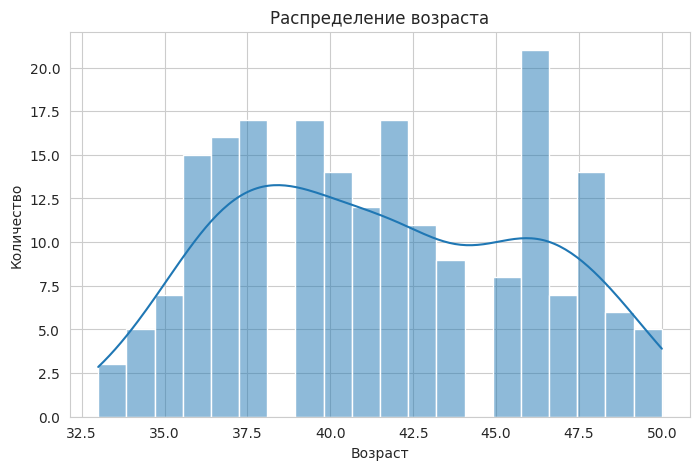

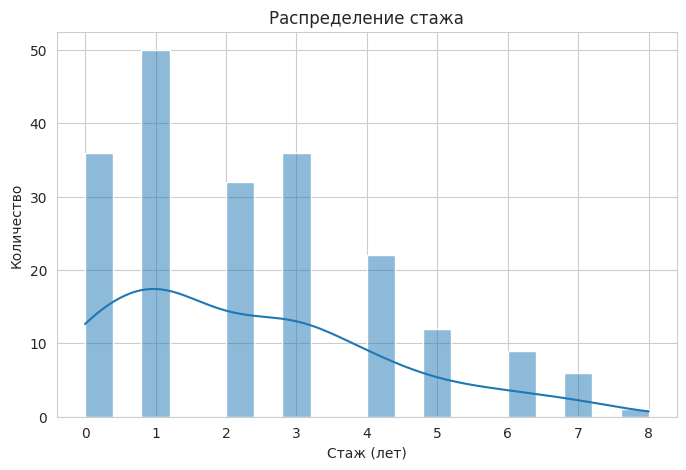

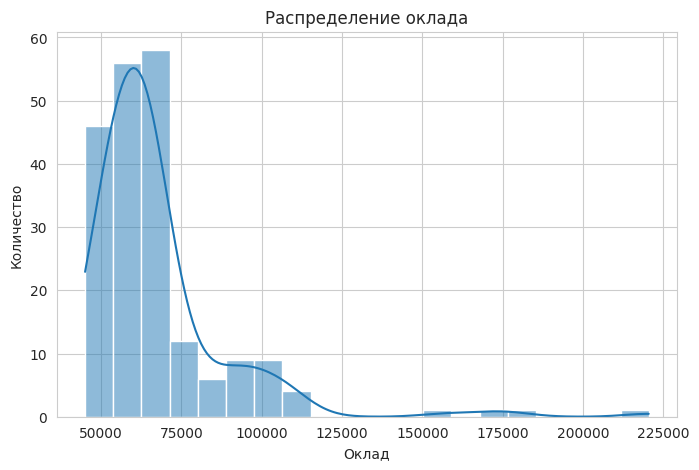

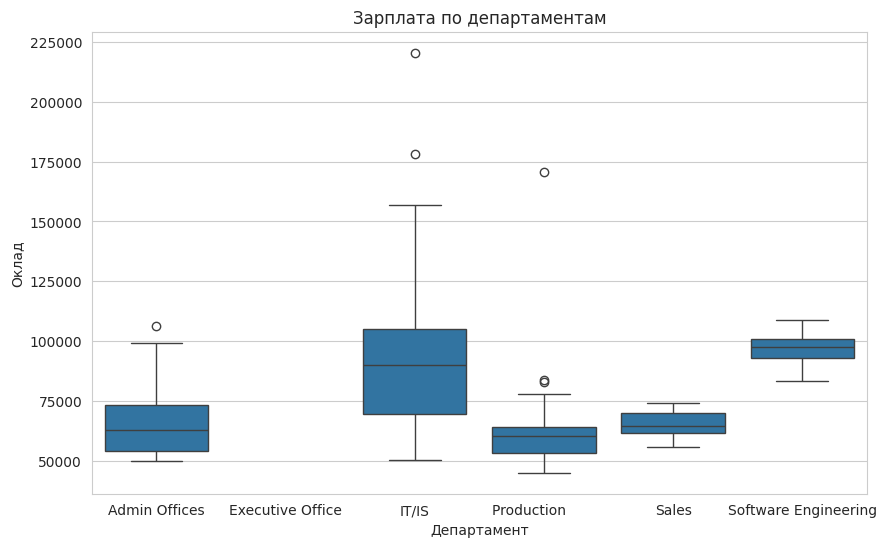

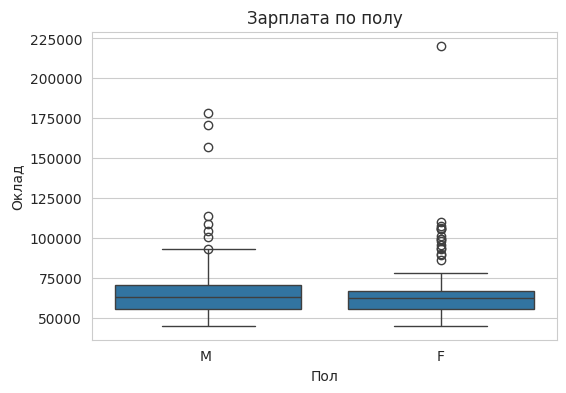

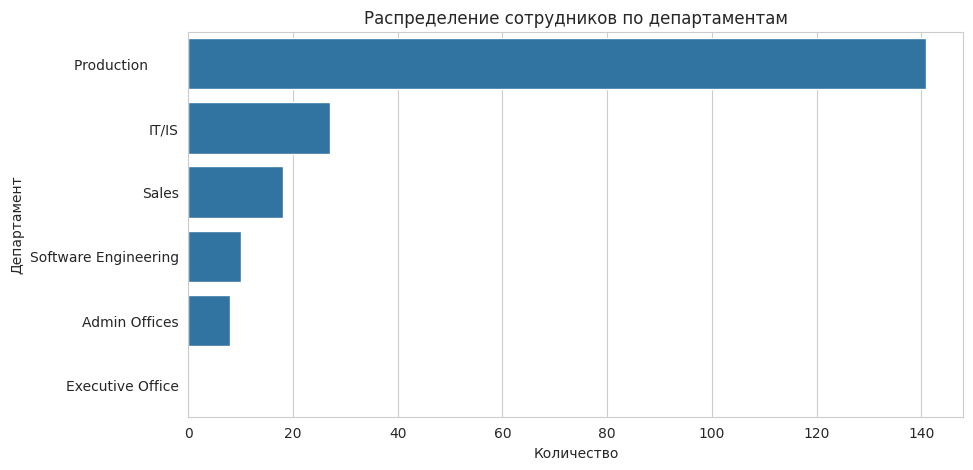

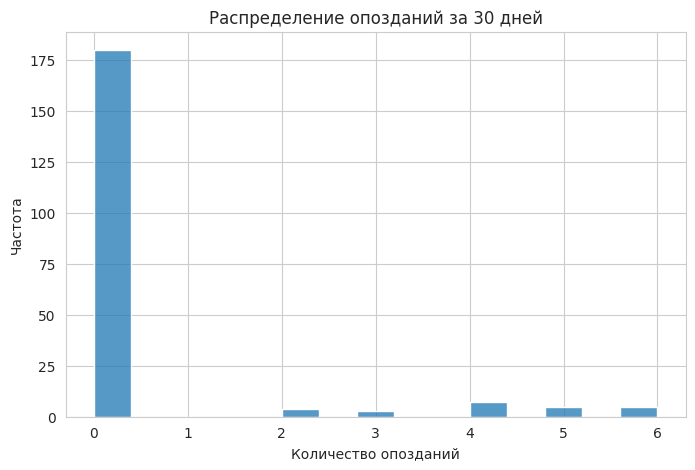

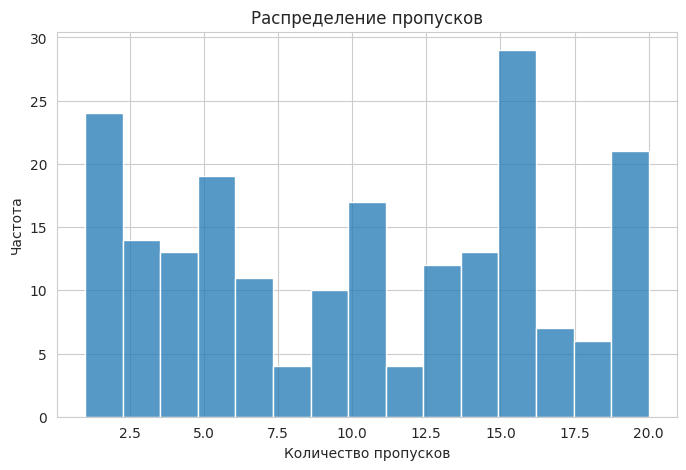

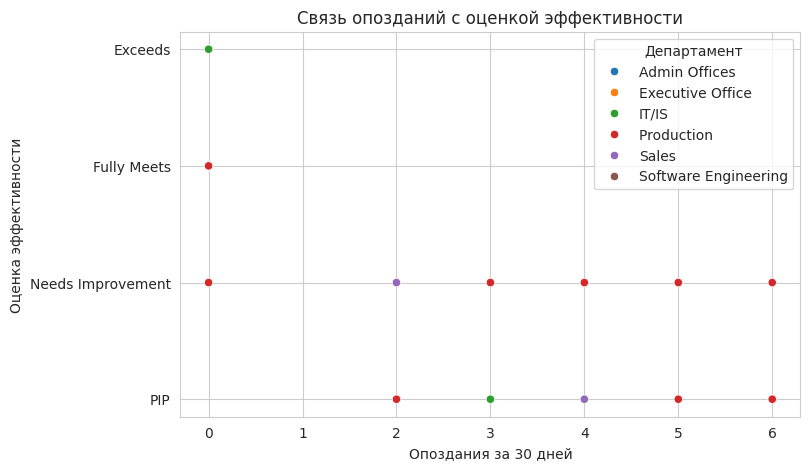

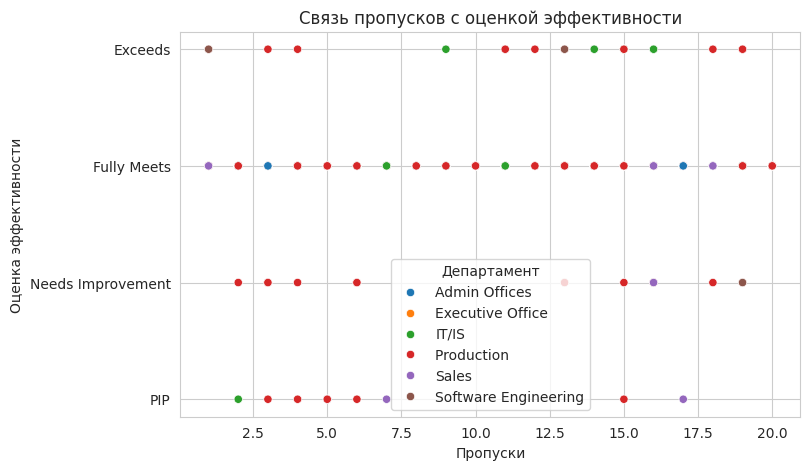

In [15]:
sns.set_style("whitegrid")

# распределение возраста
plt.figure(figsize=(8,5))
sns.histplot(df["Возраст"], bins=20, kde=True)
plt.title("Распределение возраста")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

# распределение стажа
plt.figure(figsize=(8,5))
sns.histplot(df["Стаж_лет"], bins=20, kde=True)
plt.title("Распределение стажа")
plt.xlabel("Стаж (лет)")
plt.ylabel("Количество")
plt.show()

# распределение зарплаты
plt.figure(figsize=(8,5))
sns.histplot(df["Оклад"], bins=20, kde=True)
plt.title("Распределение оклада")
plt.xlabel("Оклад")
plt.ylabel("Количество")
plt.show()

# зарплата по департаментам
plt.figure(figsize=(10,6))
sns.boxplot(x="Департамент", y="Оклад", data=df)
plt.title("Зарплата по департаментам")
plt.xlabel("Департамент")
plt.ylabel("Оклад")
plt.show()

# зарплата по полу
plt.figure(figsize=(6,4))
sns.boxplot(x="Пол", y="Оклад", data=df)
plt.title("Зарплата по полу")
plt.xlabel("Пол")
plt.ylabel("Оклад")
plt.show()

# распределение по департаментам
plt.figure(figsize=(10,5))
sns.countplot(y="Департамент", data=df, order=df["Департамент"].value_counts().index)
plt.title("Распределение сотрудников по департаментам")
plt.xlabel("Количество")
plt.ylabel("Департамент")
plt.show()

# распределение опозданий
plt.figure(figsize=(8,5))
sns.histplot(df["Опоздания_30дн"], bins=15, kde=False)
plt.title("Распределение опозданий за 30 дней")
plt.xlabel("Количество опозданий")
plt.ylabel("Частота")
plt.show()

# распределение пропусков
plt.figure(figsize=(8,5))
sns.histplot(df["Пропуски"], bins=15, kde=False)
plt.title("Распределение пропусков")
plt.xlabel("Количество пропусков")
plt.ylabel("Частота")
plt.show()

# связь опозданий и оценки эффективности
plt.figure(figsize=(8,5))
sns.scatterplot(x="Опоздания_30дн", y="Оценка", data=df, hue="Департамент")
plt.title("Связь опозданий с оценкой эффективности")
plt.xlabel("Опоздания за 30 дней")
plt.ylabel("Оценка эффективности")
plt.show()

# связь пропусков и оценки эффективности
plt.figure(figsize=(8,5))
sns.scatterplot(x="Пропуски", y="Оценка", data=df, hue="Департамент")
plt.title("Связь пропусков с оценкой эффективности")
plt.xlabel("Пропуски")
plt.ylabel("Оценка эффективности")
plt.show()

# **Оценка общего «здоровья» компании.**

In [16]:
# текучесть: доля уволенных сотрудников
текучесть = df["Уволен"].mean()
print(f"Общая текучесть: {текучесть:.2%}")

# средний оклад и медиана
средний_оклад = df["Оклад"].mean()
медианный_оклад = df["Оклад"].median()
print(f"Средний оклад: {средний_оклад:.0f}, Медианный оклад: {медианный_оклад:.0f}")

# средняя вовлеченность и удовлетворенность
средняя_вовлеченность = df["Вовлеченность"].mean()
средняя_удовлетворенность = df["Удовлетворенность"].mean()
print(f"Средняя вовлеченность: {средняя_вовлеченность:.2f}")
print(f"Средняя удовлетворенность: {средняя_удовлетворенность:.2f}")

# средний стаж и возраст
средний_стаж = df["Стаж_лет"].mean()
средний_возраст = df["Возраст"].mean()
print(f"Средний стаж: {средний_стаж:.1f} лет")
print(f"Средний возраст: {средний_возраст:.1f} лет")

# средние опоздания и пропуски
средние_опоздания = df["Опоздания_30дн"].mean()
средние_пропуски = df["Пропуски"].mean()
print(f"Среднее количество опозданий за 30 дней: {средние_опоздания:.1f}")
print(f"Среднее количество пропусков: {средние_пропуски:.1f}")


Общая текучесть: 32.84%
Средний оклад: 67161, Медианный оклад: 62658
Средняя вовлеченность: 4.10
Средняя удовлетворенность: 3.90
Средний стаж: 2.3 лет
Средний возраст: 41.5 лет
Среднее количество опозданий за 30 дней: 0.5
Среднее количество пропусков: 10.3


Общая текучесть: 32.84%

Текучесть по департаментам:
Департамент
Software Engineering    40.00%
Production              37.59%
Admin Offices           25.00%
IT/IS                   22.22%
Sales                   11.11%
Executive Office          nan%
Name: Уволен, dtype: object

Текучесть по полу:
Пол
F     32.76%
M     32.95%
Name: Уволен, dtype: object

Текучесть по стажу:
Стаж_категория
<2       30.49%
2-5      40.00%
5-10     62.50%
10-20      nan%
20+        nan%
Name: Уволен, dtype: object


/tmp/ipython-input-723623054.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  текучесть_департаменты = df.groupby("Департамент")["Уволен"].mean().sort_values(ascending=False)
/tmp/ipython-input-723623054.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  текучесть_стаж = df.groupby("Стаж_категория")["Уволен"].mean()


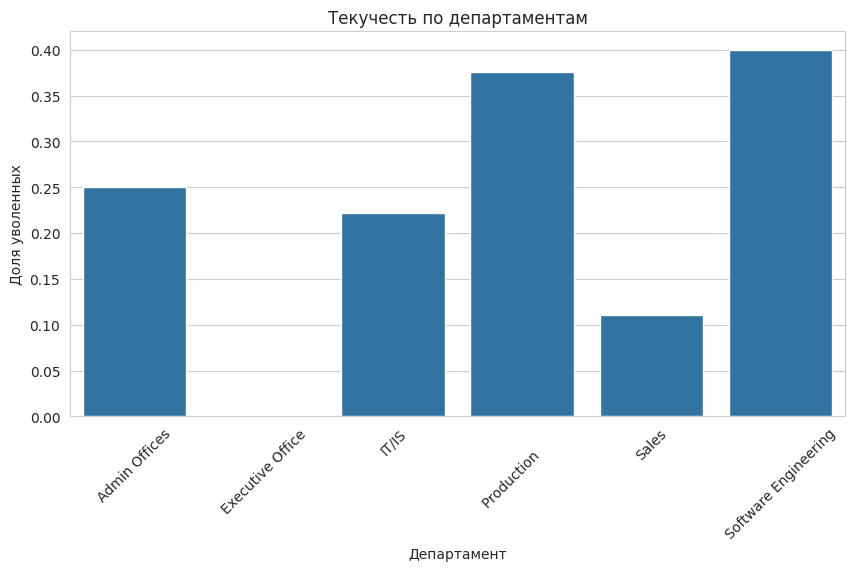

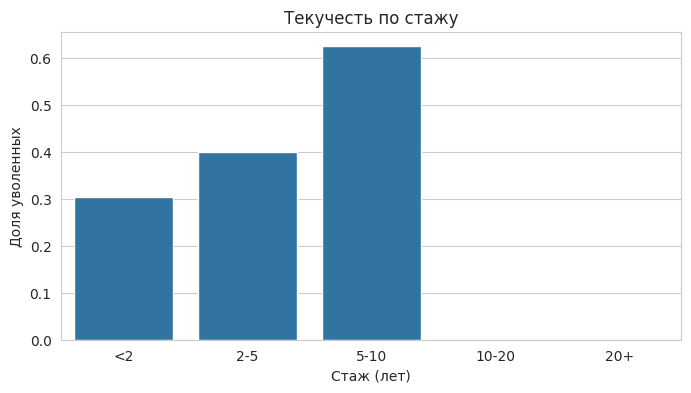

In [17]:
# текучесть по всему датасету
общая_текучесть = df["Уволен"].mean()
print(f"Общая текучесть: {общая_текучесть:.2%}")

# текучесть по департаментам
текучесть_департаменты = df.groupby("Департамент")["Уволен"].mean().sort_values(ascending=False)
print("\nТекучесть по департаментам:")
print(текучесть_департаменты.apply(lambda x: f"{x:.2%}"))

# текучесть по полу
текучесть_пол = df.groupby("Пол")["Уволен"].mean()
print("\nТекучесть по полу:")
print(текучесть_пол.apply(lambda x: f"{x:.2%}"))

# текучесть по стажу (разбиваем на группы)
bins = [0, 2, 5, 10, 20, 100]
labels = ["<2", "2-5", "5-10", "10-20", "20+"]
df["Стаж_категория"] = pd.cut(df["Стаж_лет"], bins=bins, labels=labels)
текучесть_стаж = df.groupby("Стаж_категория")["Уволен"].mean()
print("\nТекучесть по стажу:")
print(текучесть_стаж.apply(lambda x: f"{x:.2%}"))

# визуализация текучести по департаментам
plt.figure(figsize=(10,5))
sns.barplot(x=текучесть_департаменты.index, y=текучесть_департаменты.values)
plt.title("Текучесть по департаментам")
plt.ylabel("Доля уволенных")
plt.xlabel("Департамент")
plt.xticks(rotation=45)
plt.show()

# визуализация текучести по стажу
plt.figure(figsize=(8,4))
sns.barplot(x=текучесть_стаж.index, y=текучесть_стаж.values)
plt.title("Текучесть по стажу")
plt.ylabel("Доля уволенных")
plt.xlabel("Стаж (лет)")
plt.show()

**Анализ факторов, связанных с текучестью.**

Мой подход:

- посмотреть корреляции числовых признаков с увольнением (Уволен)

- сравнить средние значения признаков для уволенных и работающих

- использовать визуализации, чтобы сразу видеть различия

Корреляции числовых признаков с текучестью:
Уволен                1.000000
Статус_работы_ID      0.939960
Стаж_лет              0.282289
Опоздания_30дн        0.214411
Менеджер_ID           0.191247
Должность_ID          0.147443
Семейный_статус_ID    0.106140
Пропуски              0.105174
ID                    0.102028
В_браке_ID            0.086615
С_ярмарки_вакансий    0.073942
Департамент_ID        0.015210
Возраст               0.007378
Пол_ID                0.002066
Удовлетворенность    -0.027475
Оклад                -0.055733
Вовлеченность        -0.067223
Проекты              -0.111993
Оценка_ID            -0.133153
Почтовый_индекс      -0.159858
Name: Уволен, dtype: float64

Средние значения признаков по статусу:
               Оклад    Возраст  Стаж_лет  Опоздания_30дн   Пропуски  \
Уволен                                                                 
0       68023.598540  41.452555  1.948905        0.277372   9.824818   
1       65397.597015  41.522388  3.089552        0.

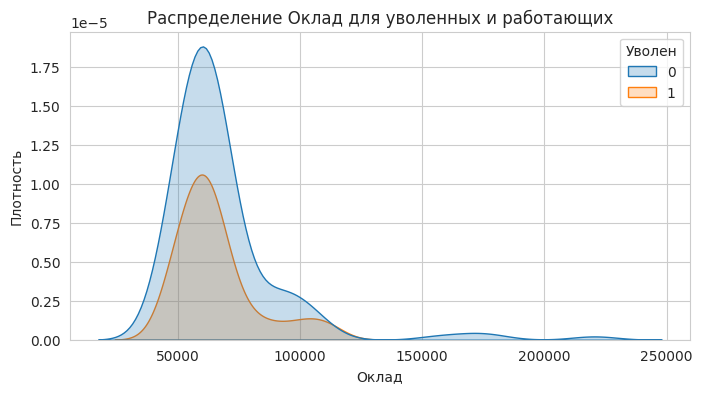

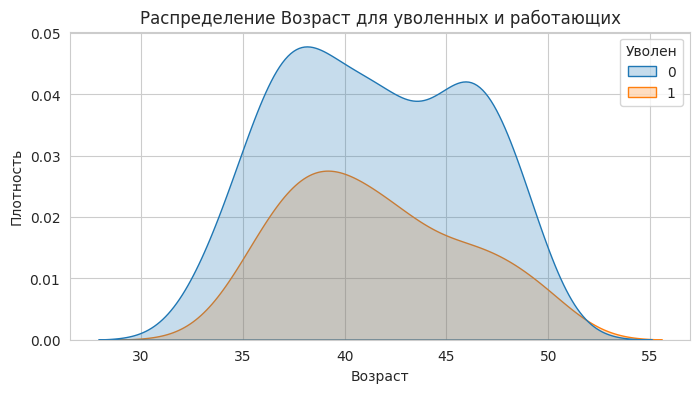

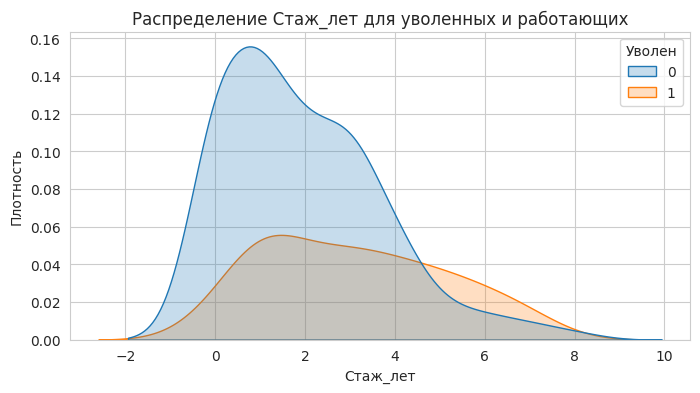

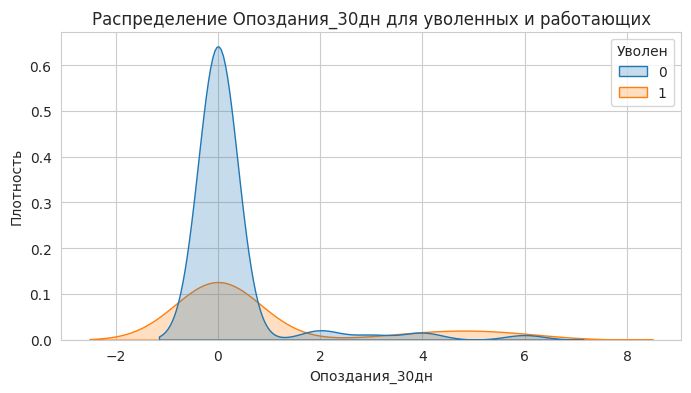

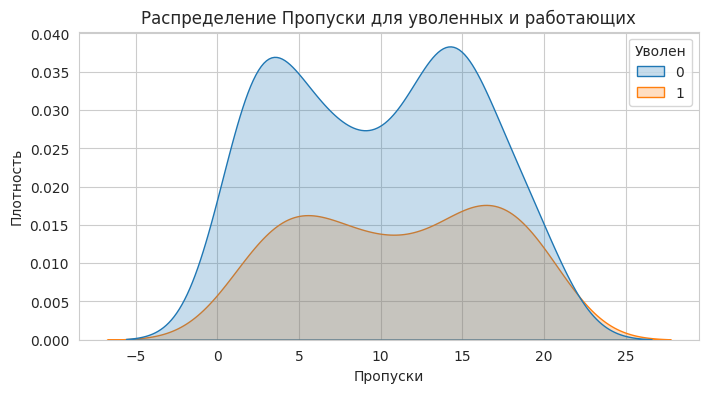

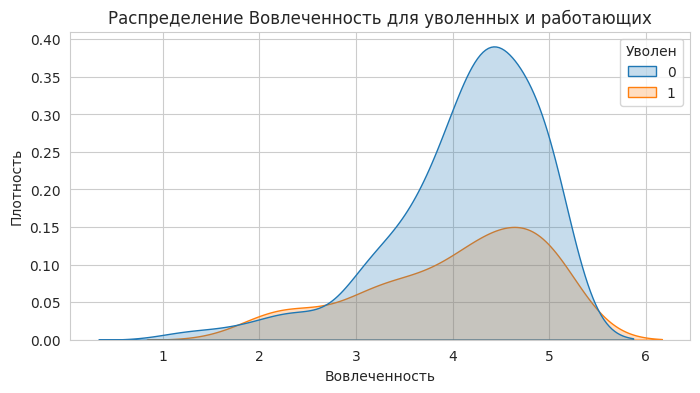

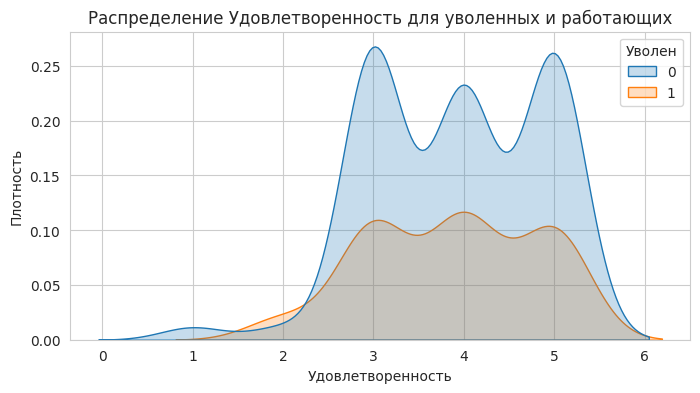

In [18]:
# корреляция числовых признаков с увольнением
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
корреляции = df[num_cols].corr()["Уволен"].sort_values(ascending=False)
print("Корреляции числовых признаков с текучестью:")
print(корреляции)

# сравнение средних значений признаков по статусу сотрудника
средние_по_увольнению = df.groupby("Уволен")[["Оклад", "Возраст", "Стаж_лет", "Опоздания_30дн", "Пропуски", "Вовлеченность", "Удовлетворенность"]].mean()
print("\nСредние значения признаков по статусу:")
print(средние_по_увольнению)

# 3. Визуализация распределений уволенных vs работающих
признаки = ["Оклад", "Возраст", "Стаж_лет", "Опоздания_30дн", "Пропуски", "Вовлеченность", "Удовлетворенность"]

for col in признаки:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df, x=col, hue="Уволен", fill=True)
    plt.title(f"Распределение {col} для уволенных и работающих")
    plt.xlabel(col)
    plt.ylabel("Плотность")
    plt.show()

**Промежуточный вывод по текучести персонала:**

* **Текучесть сотрудников:** около **33%** — каждый третий человек увольняется.
* **Средний возраст сотрудников:** **41 год**.
* **Средний стаж:** около **2,3 года**.
* **Средний оклад:** **67 161 руб.**, медиана — **62 658 руб.**
* **Вовлеченность:** 4,1 из 5
* **Удовлетворенность работой:** 3,9 из 5
* **Опозданий за 30 дней:** в среднем **0,5**, пропусков — **10,3**
---

**Что влияет на текучесть**

* Главные факторы: **статус работы, стаж, дисциплина (опоздания)**
* Почти не влияют: возраст, пол, оклад, вовлеченность, удовлетворенность

**Сравнение уволенных и работающих**

* Уволенные имеют чуть **меньший оклад**, **больше стаж**, **чаще опаздывают** и **больше пропусков**
* Вовлеченность и удовлетворенность почти одинаковы

---

**Ключевой вывод**

* **Проблемные отделы:** Software Engineering и Production
* **Риск текучести:** сотрудники со стажем 2–10 лет
* **Что стоит улучшить:** карьерный рост, условия работы, дисциплину, управление в отделах с высокой текучестью


/tmp/ipython-input-2114154404.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_turnover = df.groupby("Департамент")["Уволен"].mean() * 100
/tmp/ipython-input-2114154404.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_turnover = df.groupby("Должность")["Уволен"].mean() * 100
/tmp/ipython-input-2114154404.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_turnover = df.groupby("Стаж_категория"

Текучесть по департаментам (%):
 Департамент
Admin Offices           25.000000
Executive Office              NaN
IT/IS                   22.222222
Production              37.588652
Sales                   11.111111
Software Engineering    40.000000
Name: Уволен, dtype: float64

Текучесть по должностям (%):
 Должность
Accountant I                      0.000000
Administrative Assistant         66.666667
Area Sales Manager                6.666667
BI Developer                           NaN
BI Director                            NaN
CIO                               0.000000
Data Analyst                     16.666667
Data Analyst                    100.000000
Data Architect                         NaN
Database Administrator           50.000000
Director of Operations            0.000000
Director of Sales                      NaN
Enterprise Architect                   NaN
IT Director                       0.000000
IT Manager - DB                        NaN
IT Manager - Infra                0.

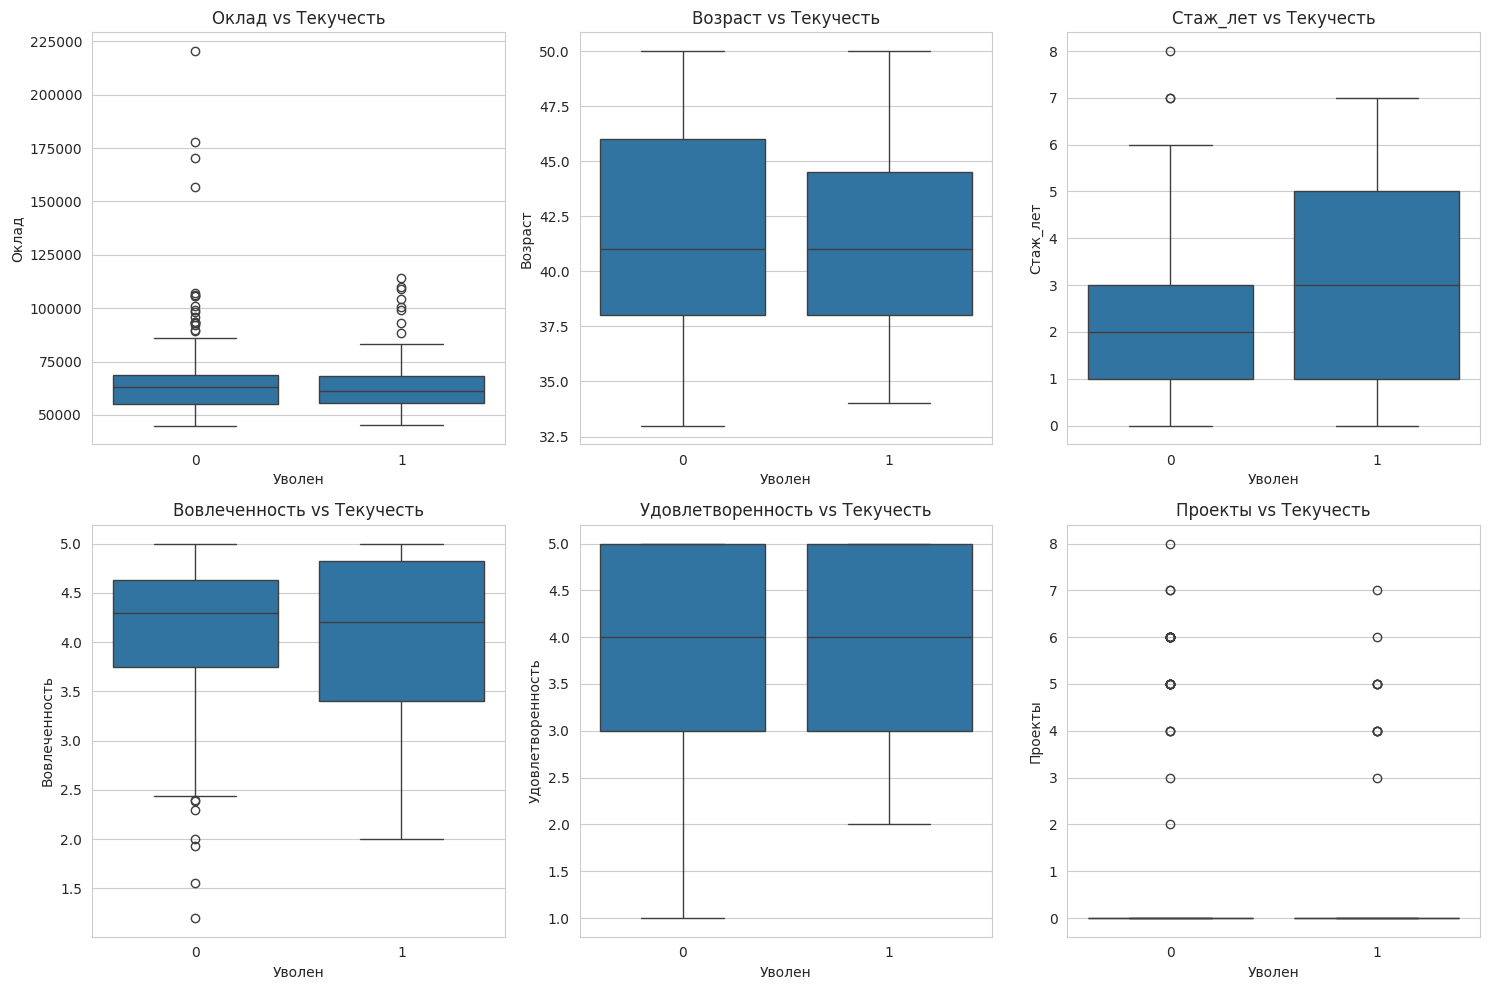

In [19]:
# текучесть по департаментам
dept_turnover = df.groupby("Департамент")["Уволен"].mean() * 100
print("Текучесть по департаментам (%):\n", dept_turnover)

# текучесть по должностям
position_turnover = df.groupby("Должность")["Уволен"].mean() * 100
print("\nТекучесть по должностям (%):\n", position_turnover)

# текучесть по полу
gender_turnover = df.groupby("Пол")["Уволен"].mean() * 100
print("\nТекучесть по полу (%):\n", gender_turnover)

# текучесть по стажу
# создаём категории стажа
bins = [0, 2, 5, 10, 20, 100]
labels = ["<2", "2-5", "5-10", "10-20", "20+"]
df["Стаж_категория"] = pd.cut(df["Стаж_лет"], bins=bins, labels=labels, right=False)
tenure_turnover = df.groupby("Стаж_категория")["Уволен"].mean() * 100
print("\nТекучесть по стажу (%):\n", tenure_turnover)

# визуализация зависимости текучести от числовых факторов
num_cols = ["Оклад", "Возраст", "Стаж_лет", "Вовлеченность", "Удовлетворенность", "Проекты"]
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="Уволен", y=col, data=df)
    plt.title(f"{col} vs Текучесть")
plt.tight_layout()
plt.show()

## Общий вывод по здоровью компании

1. **Общая текучесть**: 32.8%, каждый третий сотрудник покидает компанию.

2. **Текучесть по департаментам**:

   * Software Engineering: 40%
   * Production: 37.6%
   * Admin Offices: 25%
   * IT/IS: 22.2%
   * Sales:11.1%
   * Executive Office: нет данных (мало сотрудников)
     
     - Наибольший риск текучести в разработке и производстве.

3. **Текучесть по должностям**:

   * Высокая текучесть у Production Technician II (42.9%), Administrative Assistant (66.7%), Production Technician I (36.7%)
   * Полностью стабильные позиции: President & CEO, CIO, IT Director — текучесть 0%
     
     - Некоторые должности сильно уязвимы, особенно операционные и вспомогательные.

4. **Текучесть по полу**:

   * Женщины: 32.8%, мужчины: 33%
     
     - Разницы практически нет.

5. **Текучесть по стажу**:

   * Стаж <2 года: 23.3%
   * 2–5 лет: 32.2%
   * 5–10 лет: 64.3%

     - Наибольшая текучесть среди сотрудников со стажем 5–10 лет.

---

**Ключевые наблюдения**:

* Основной риск текучести-в отделах разработки и производства.
* Определённые должности сильно подвержены уходу, особенно средние и младшие позиции.
* Пол почти не влияет на текучесть.
* Стаж 5–10 лет-критический период, возможно, уходят опытные сотрудники.

# Каков текущий уровень текучести персонала?

/tmp/ipython-input-1716105792.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_turnover = df.groupby("Департамент")["Уволен"].mean() * 100
/tmp/ipython-input-1716105792.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_turnover.values, y=dept_turnover.index, palette="coolwarm")


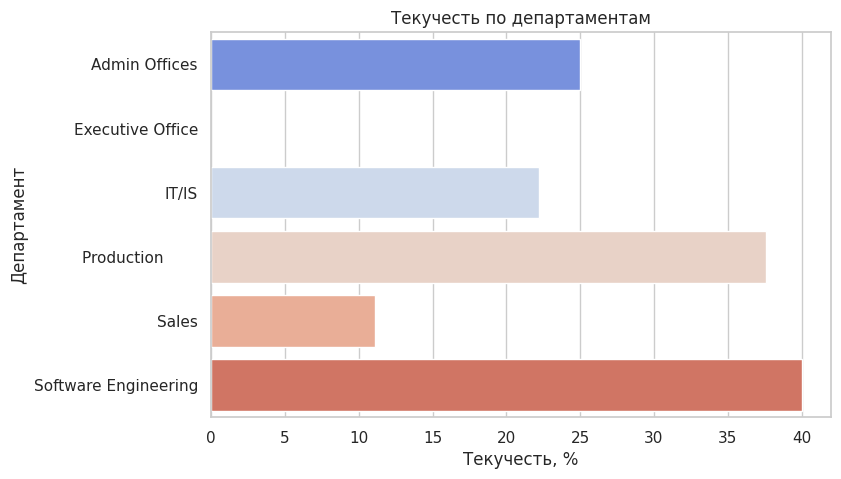

/tmp/ipython-input-1716105792.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_turnover = df.groupby("Должность")["Уволен"].mean() * 100
/tmp/ipython-input-1716105792.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_turnover.values, y=position_turnover.index, palette="viridis")


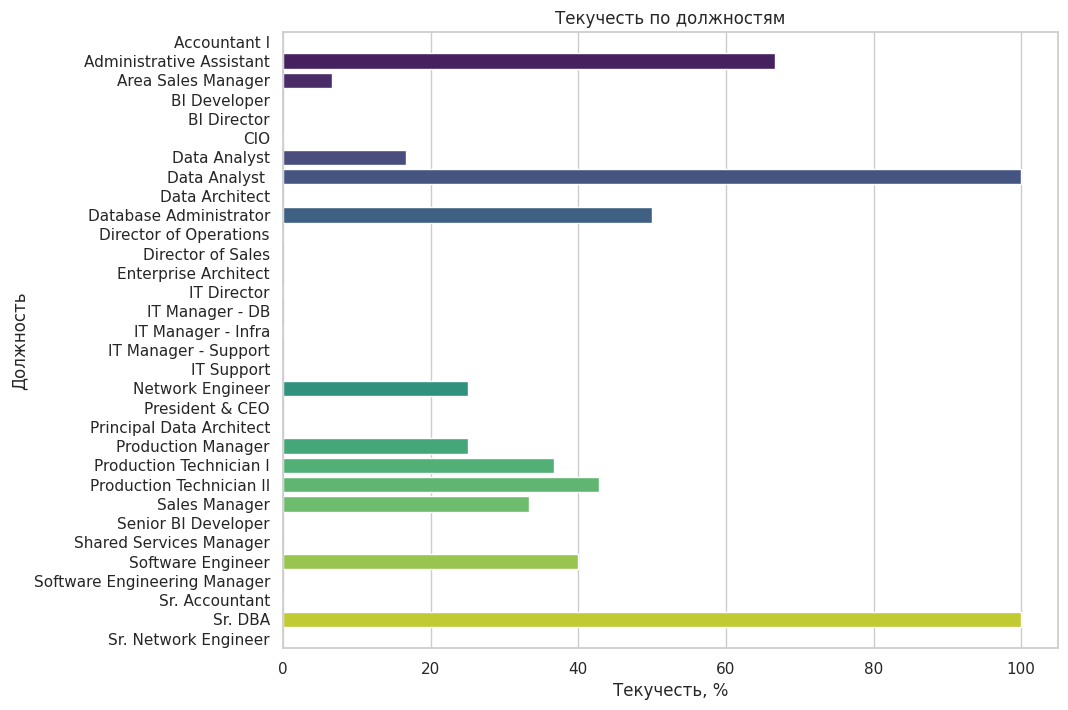

/tmp/ipython-input-1716105792.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_turnover = df.groupby("Стаж_категория")["Уволен"].mean() * 100
/tmp/ipython-input-1716105792.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tenure_turnover.index, y=tenure_turnover.values, palette="magma")


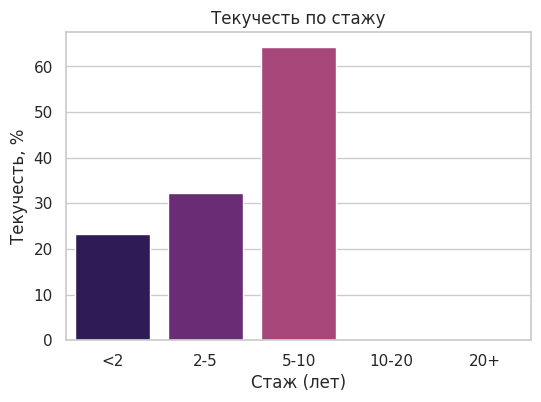

In [20]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# текучесть по департаментам
dept_turnover = df.groupby("Департамент")["Уволен"].mean() * 100
dept_turnover = dept_turnover.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=dept_turnover.values, y=dept_turnover.index, palette="coolwarm")
plt.xlabel("Текучесть, %")
plt.ylabel("Департамент")
plt.title("Текучесть по департаментам")
plt.show()

# текучесть по должностям
position_turnover = df.groupby("Должность")["Уволен"].mean() * 100
position_turnover = position_turnover.sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=position_turnover.values, y=position_turnover.index, palette="viridis")
plt.xlabel("Текучесть, %")
plt.ylabel("Должность")
plt.title("Текучесть по должностям")
plt.show()

# текучесть по стажу
tenure_turnover = df.groupby("Стаж_категория")["Уволен"].mean() * 100

plt.figure(figsize=(6,4))
sns.barplot(x=tenure_turnover.index, y=tenure_turnover.values, palette="magma")
plt.xlabel("Стаж (лет)")
plt.ylabel("Текучесть, %")
plt.title("Текучесть по стажу")
plt.show()

**Текучесть сотрудников**

**Общая текучесть:** 32.8%

* Средний оклад: 67 161, медианный оклад: 62 658
* Средняя вовлечённость: 4.10
* Средняя удовлетворённость: 3.90
* Средний стаж: 2.3 года
* Средний возраст: 41.5 лет
* Среднее количество опозданий за 30 дней: 0.5
* Среднее количество пропусков: 10.3

**Текучесть по департаментам:**

* Software Engineering: 40%
* Production: 37.6%
* Admin Offices: 25%
* IT/IS: 22.2%
* Sales: 11.1%
* Executive Office: нет данных

**Текучесть по должностям:**

* Высокая текучесть у Administrative Assistant (66.7%), Production Technician II (42.9%), Software Engineer (40%)
* Низкая или отсутствует у IT Support, IT Director, President & CEO

**Текучесть по полу:**

* Женщины: 32.8%
* Мужчины: 32.9%
* Разницы практически нет

**Текучесть по стажу:**

* <2 года: 23.3%
* 2–5 лет: 32%
* 5–10 лет: 64.3%
* 10–20 лет и 20+ лет: данных мало

**Корреляции числовых признаков с увольнениями:**

* Наиболее сильная связь: Статус работы (0.94), Стаж (0.28)
* Слабая или отрицательная связь: возраст, пол, вовлечённость, удовлетворённость, оклад

**Средние показатели по статусу:**

| Статус    | Оклад  | Возраст | Стаж (лет) | Опоздания | Пропуски | Вовлечённость | Удовлетворённость |
| --------- | ------ | ------- | ---------- | --------- | -------- | ------------- | ----------------- |
| Не уволен | 68 024 | 41.45   | 1.95       | 0.28      | 9.82     | 4.14          | 3.92              |
| Уволен    | 65 398 | 41.51   | 3.09       | 0.93      | 11.15    | 4.02          | 3.87              |

**Выводы:**

* Текучесть сильно растёт после 5 лет стажа.
* Определённые должности (например, Administrative Assistant, Production Technician II, Software Engineer) требуют внимания по удержанию.
* Разница по полу и возрасту практически отсутствует.
* Корреляции показывают, что на текучесть сильнее всего влияют статус работы и стаж, а не вовлечённость или оклад.


/tmp/ipython-input-1068130052.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1068130052.py:7: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipython-input-1068130052.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1068130052.py:21: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipython-input-1068130052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue`

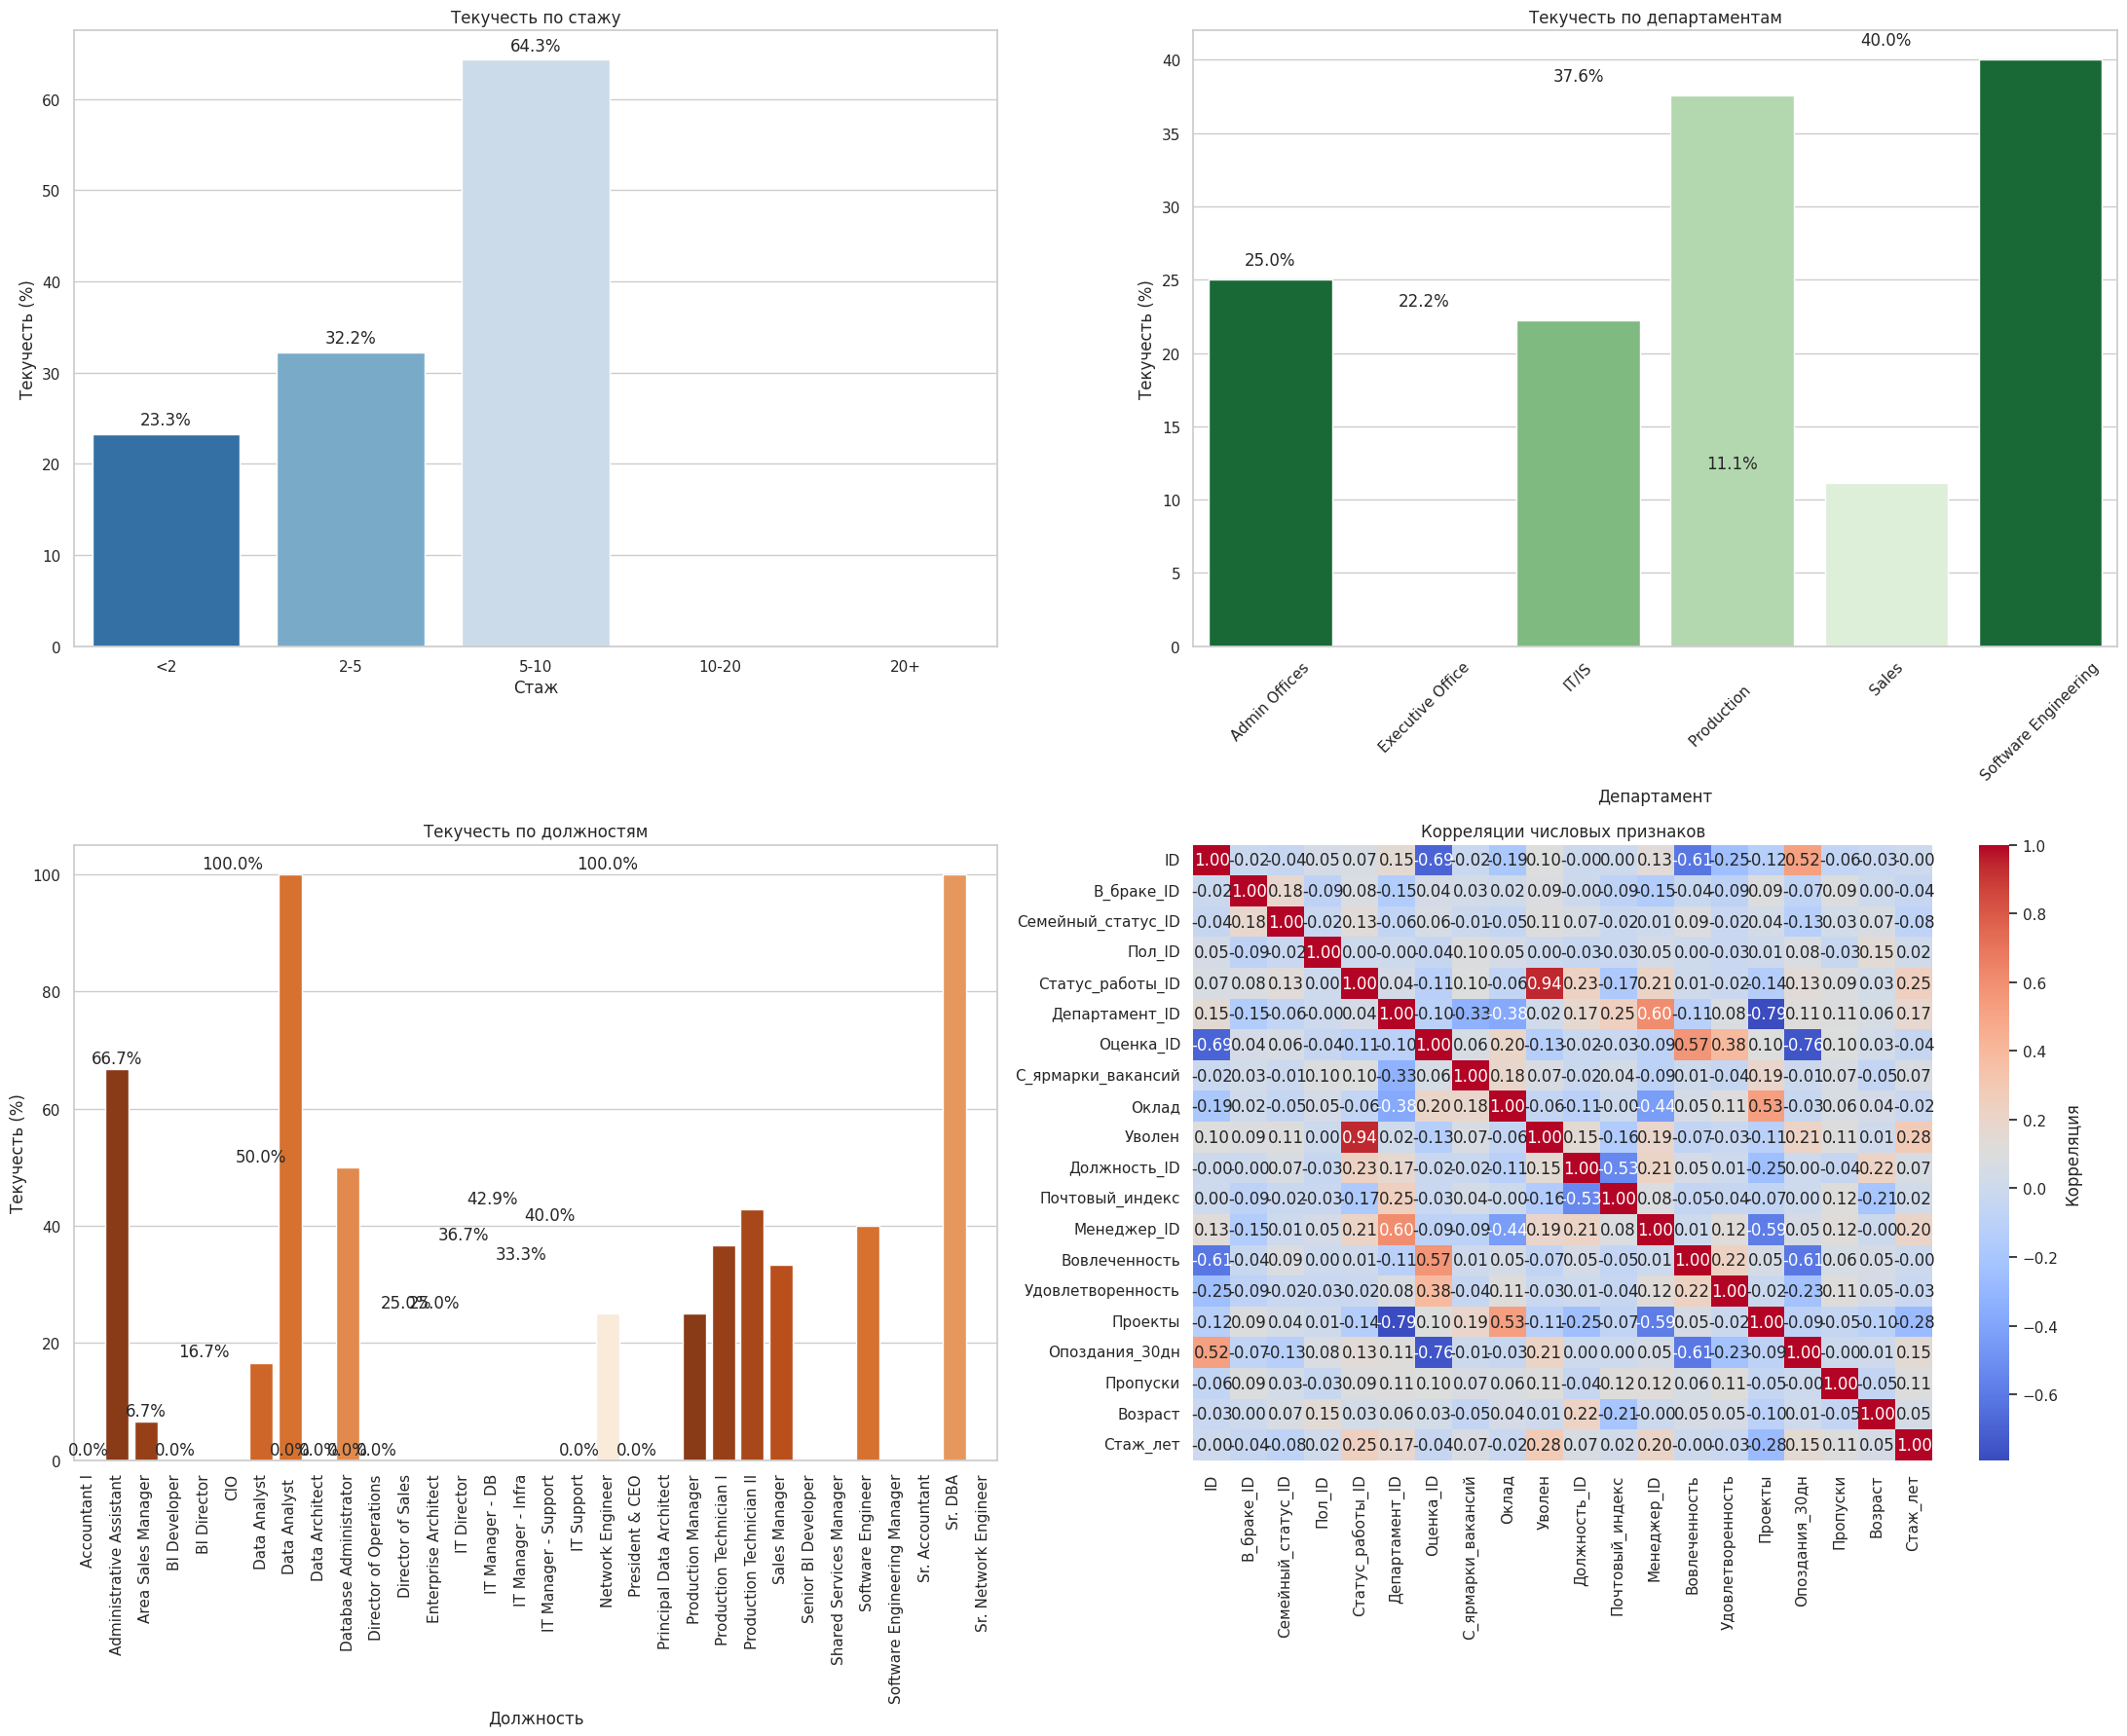

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(22, 18))

# текучесть по стажу
plt.subplot(2, 2, 1)
tenure_turnover = df.groupby("Стаж_категория", observed=True)["Уволен"].mean() * 100
sns.barplot(
    x=tenure_turnover.index,
    y=tenure_turnover.values,
    palette=sns.color_palette("Blues_r", len(tenure_turnover))
)
plt.title("Текучесть по стажу")
plt.ylabel("Текучесть (%)")
plt.xlabel("Стаж")
for i, v in enumerate(tenure_turnover.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

# текучесть по департаментам
plt.subplot(2, 2, 2)
dept_turnover = df.groupby("Департамент", observed=True)["Уволен"].mean() * 100
sns.barplot(
    x=dept_turnover.index,
    y=dept_turnover.values,
    palette=sns.color_palette("Greens_r", len(dept_turnover))
)
plt.title("Текучесть по департаментам")
plt.ylabel("Текучесть (%)")
plt.xlabel("Департамент")
plt.xticks(rotation=45)
for i, v in enumerate(dept_turnover.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

# текучесть по должностям
plt.subplot(2, 2, 3)
position_turnover = df.groupby("Должность", observed=True)["Уволен"].mean() * 100
sns.barplot(
    x=position_turnover.index,
    y=position_turnover.values,
    palette=sns.color_palette("Oranges_r", len(position_turnover))
)
plt.title("Текучесть по должностям")
plt.ylabel("Текучесть (%)")
plt.xlabel("Должность")
plt.xticks(rotation=90)
for i, v in enumerate(position_turnover.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

# корреляции числовых признаков с текучестью
plt.subplot(2, 2, 4)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Корреляция'})
plt.title("Корреляции числовых признаков")

plt.tight_layout()
plt.show()

## Вывод по факторам текучести

1. **Стаж работы**

   * Люди с небольшим опытом работы (<2 лет) уходят реже (\~23%),
   * а сотрудники со стажем 5–10 лет уходят чаще всего (\~64%).
   * Вывод: текучесть выше среди сотрудников среднего стажа, возможно, из-за карьерного роста или неудовлетворенности.

2. **Департамент**

   * Самая высокая текучесть: Software Engineering (40%) и Production (38%).
   * Низкая текучесть: Sales (11%) и IT/IS (22%).
   * Вывод: некоторые департаменты более “рискованные” по удержанию сотрудников — стоит изучить причины ухода внутри этих команд.

3. **Должность**

   * Наибольшая текучесть у Production Technician II (43%) и Software Engineer (40%).
   * Нулевая текучесть у некоторых административных и топ-менеджерских ролей.
   * Вывод: позиции с высокой нагрузкой и более стандартными карьерными путями имеют более высокий риск ухода.

4. **Пол**

   * Мужчины и женщины уходят примерно одинаково (\~33%).
   * Вывод: пол не является значимым фактором текучести в этой компании.

5. **Корреляции числовых признаков**

   * Самые сильные положительные связи с увольнением: `Статус_работы_ID` и `Стаж_лет`.
   * Остальные признаки (возраст, вовлеченность, оклад) почти не коррелируют.
   * Вывод: ключевые факторы-стаж и тип работы.




# 	Что можно сказать о распределении фонда оплаты труда (ФОТ)?

Средняя и медианная зарплата:

In [22]:
df["Оклад"].mean(), df["Оклад"].median()

(np.float64(67161.13725490196), 62658.0)

Зарплата по статусу увольнения:

In [23]:
df.groupby("Уволен")["Оклад"].mean()

,Оклад
Уволен,
0,68023.598540
1,65397.597015


Корреляция с текучестью:

In [24]:
df[["Оклад", "Уволен"]].corr()

,Оклад,Уволен
Оклад,1.000000,-0.055733
Уволен,-0.055733,1.000000


/tmp/ipython-input-244709100.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Департамент", y="Оклад", data=df, palette="Set2")
/tmp/ipython-input-244709100.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Уволен", y="Оклад", data=df, palette="Set1")


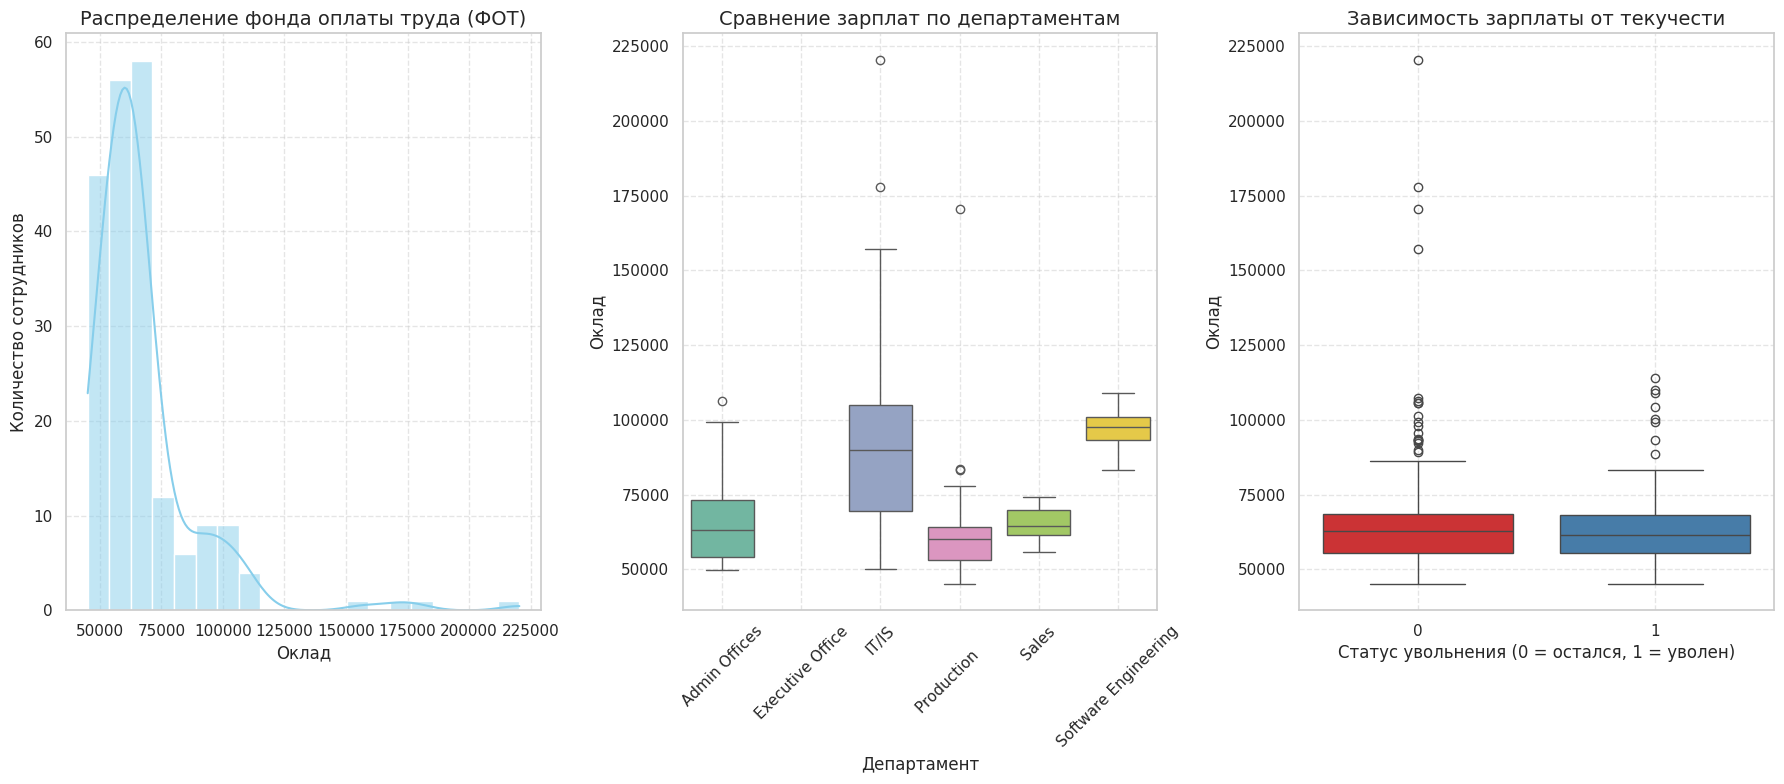

In [25]:
plt.figure(figsize=(18, 8))

# uистограмма зарплат
plt.subplot(1, 3, 1)
sns.histplot(df["Оклад"], bins=20, kde=True, color="skyblue")
plt.title("Распределение фонда оплаты труда (ФОТ)", fontsize=14)
plt.xlabel("Оклад", fontsize=12)
plt.ylabel("Количество сотрудников", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# boxplot зарплат по департаменту
plt.subplot(1, 3, 2)
sns.boxplot(x="Департамент", y="Оклад", data=df, palette="Set2")
plt.title("Сравнение зарплат по департаментам", fontsize=14)
plt.xlabel("Департамент", fontsize=12)
plt.ylabel("Оклад", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# boxplot зарплат по статусу увольнения
plt.subplot(1, 3, 3)
sns.boxplot(x="Уволен", y="Оклад", data=df, palette="Set1")
plt.title("Зависимость зарплаты от текучести", fontsize=14)
plt.xlabel("Статус увольнения (0 = остался, 1 = уволен)", fontsize=12)
plt.ylabel("Оклад", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## Вывод по фонду оплаты труда (ФОТ)

Средний и медианный оклад:

Средний оклад — ~67 161, медианный — 62 658.

Разница между средним и медианным говорит о наличии выбросов с высокими зарплатами, которые тянут среднее вверх.

Зависимость зарплаты от текучести:

Средний оклад оставшихся сотрудников — ~68 024, уволившихся — ~65 398.

Разница невелика, корреляция между зарплатой и текучестью — -0.056. Это говорит о том, что зарплата не является сильным фактором текучести, хотя уволившиеся немного ниже оплачивались в среднем.

# Какие факторы влияют на эффективность сотрудников `Performance Score`?

/tmp/ipython-input-1770190795.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_means = df.groupby("Оценка")[numerical_features].mean()
/tmp/ipython-input-1770190795.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Оценка", y="Оклад", data=df, palette="Blues_d")


                             ID  В_браке_ID  Семейный_статус_ID    Пол_ID  \
Оценка                                                                      
Exceeds            10015.904762    0.285714            0.761905  0.428571   
Fully Meets        10155.803797    0.430380            0.835443  0.417722   
Needs Improvement  10288.437500    0.375000            0.625000  0.500000   
PIP                10303.666667    0.222222            0.555556  0.555556   
Unknown                     NaN         NaN                 NaN       NaN   

                   Статус_работы_ID  Департамент_ID  Оценка_ID  \
Оценка                                                           
Exceeds                    1.714286        4.476190   4.000000   
Fully Meets                2.360759        4.563291   3.000000   
Needs Improvement          2.937500        4.875000   2.000000   
PIP                        2.222222        5.111111   1.222222   
Unknown                         NaN             NaN        NaN  

/tmp/ipython-input-1770190795.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Оценка", y="Вовлеченность", data=df, palette="Greens_d")
/tmp/ipython-input-1770190795.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Оценка", y="Удовлетворенность", data=df, palette="Oranges_d")
/tmp/ipython-input-1770190795.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Оценка", y="Стаж_лет", data=df, palette="Purples_d")


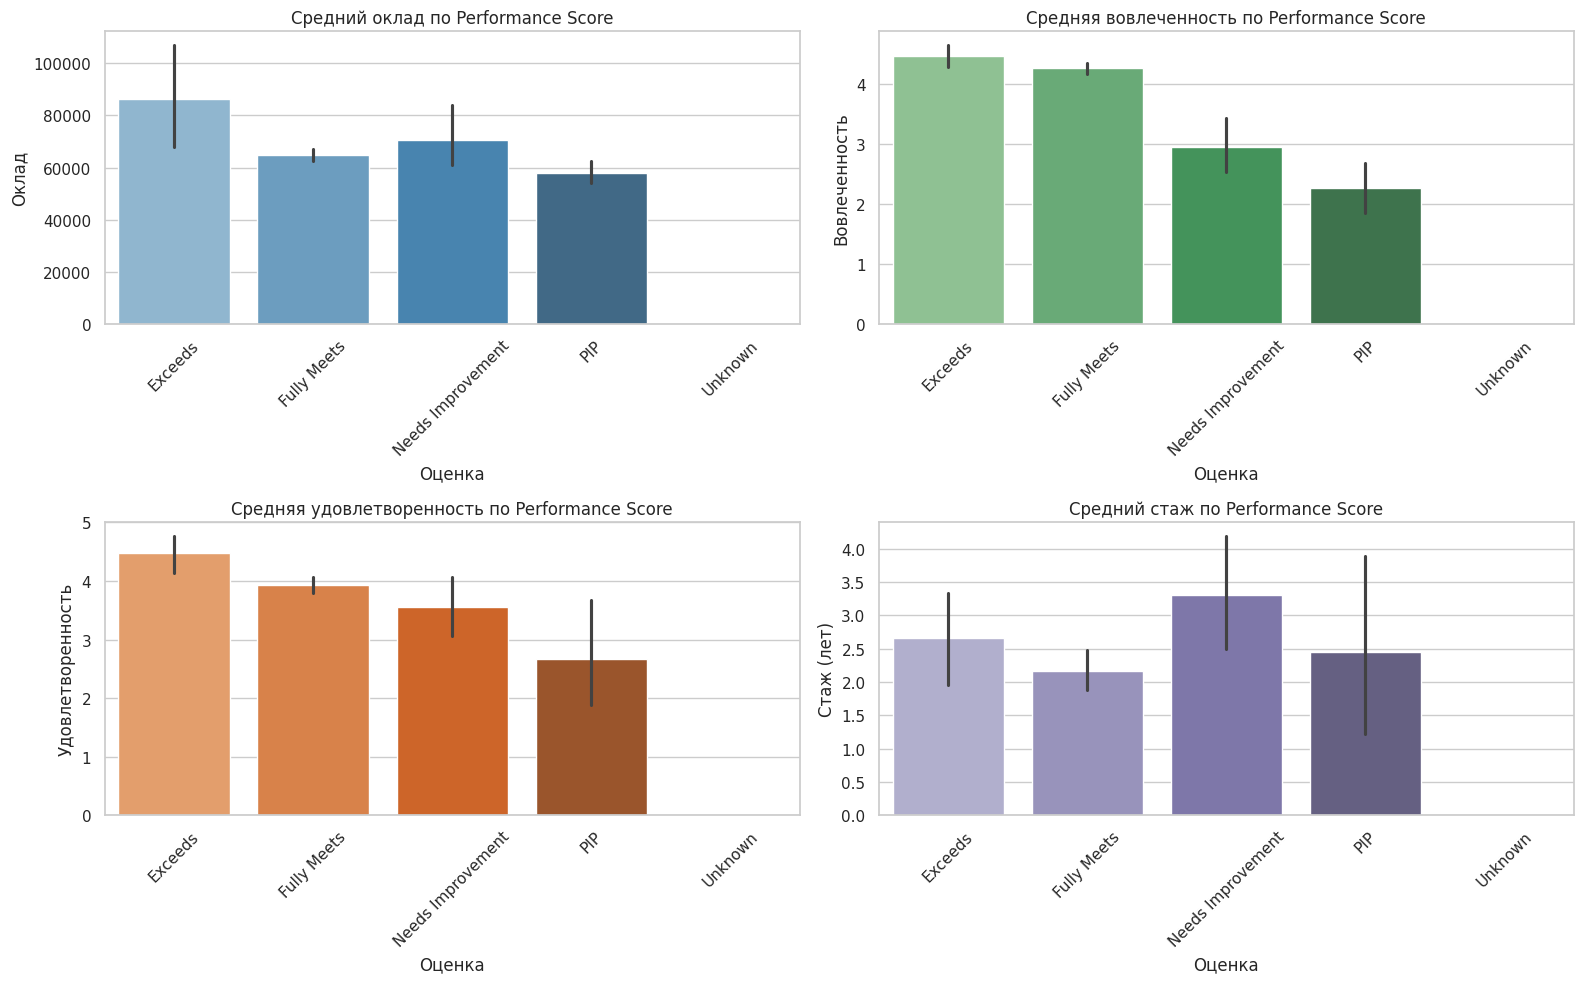

In [26]:
# обработка пропусков
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# числовые признакизаполняем медианой
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

# категориальные признаки заполняем "Unknown"
for col in categorical_features:
    if isinstance(df[col].dtype, pd.CategoricalDtype):
        if "Unknown" not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories("Unknown")
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna("Unknown")

# средние значения числовых признаков по Performance Score
performance_means = df.groupby("Оценка")[numerical_features].mean()
print(performance_means)

# визуализация влияния факторов
plt.figure(figsize=(16,10))

# средний оклад по оценке
plt.subplot(2,2,1)
sns.barplot(x="Оценка", y="Оклад", data=df, palette="Blues_d")
plt.title("Средний оклад по Performance Score")
plt.ylabel("Оклад")
plt.xticks(rotation=45)

# средняя вовлеченность по оценке
plt.subplot(2,2,2)
sns.barplot(x="Оценка", y="Вовлеченность", data=df, palette="Greens_d")
plt.title("Средняя вовлеченность по Performance Score")
plt.ylabel("Вовлеченность")
plt.xticks(rotation=45)

# средняя удовлетворенность по оценке
plt.subplot(2,2,3)
sns.barplot(x="Оценка", y="Удовлетворенность", data=df, palette="Oranges_d")
plt.title("Средняя удовлетворенность по Performance Score")
plt.ylabel("Удовлетворенность")
plt.xticks(rotation=45)

# средний стаж по оценке
plt.subplot(2,2,4)
sns.barplot(x="Оценка", y="Стаж_лет", data=df, palette="Purples_d")
plt.title("Средний стаж по Performance Score")
plt.ylabel("Стаж (лет)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

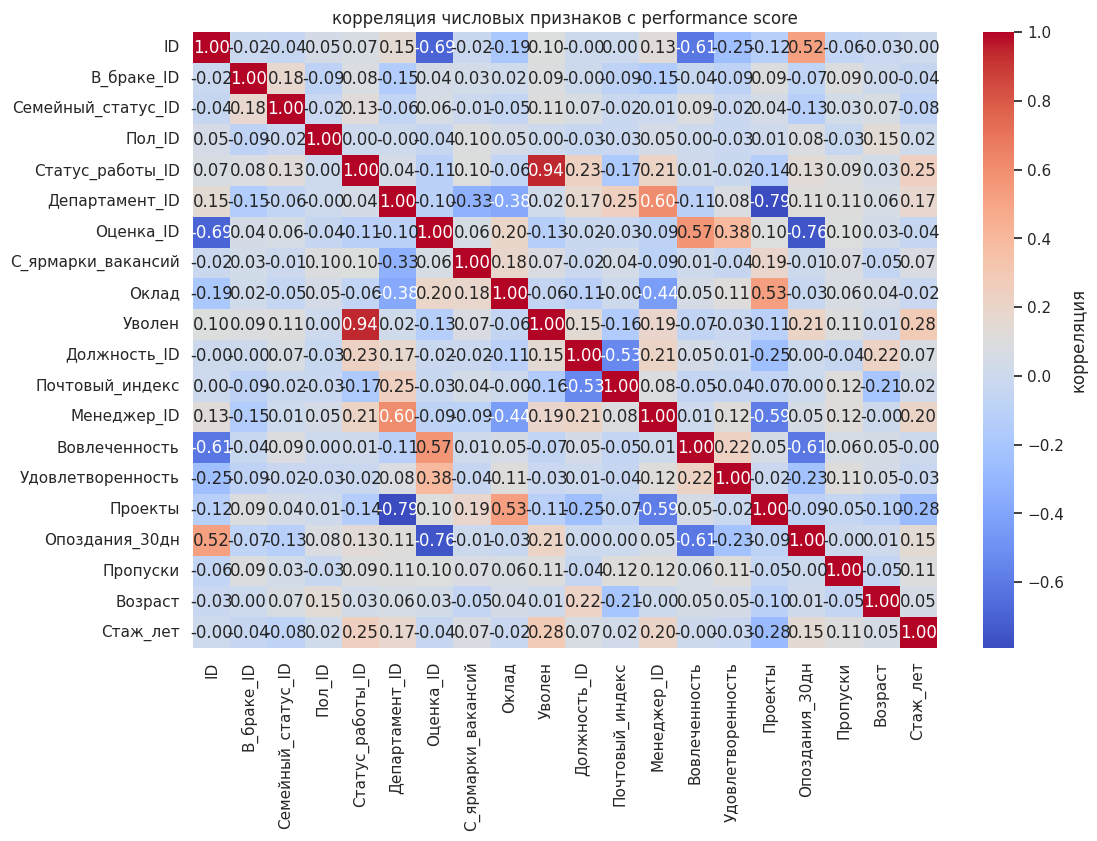

In [27]:
# корреляционная матрица
plt.figure(figsize=(12,8))
numerical_for_corr = numerical_features.copy()
if "Оценка_ID" not in numerical_for_corr:
    numerical_for_corr.append("Оценка_ID")

corr_matrix = df[numerical_for_corr].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'корреляция'})
plt.title("корреляция числовых признаков с performance score")
plt.show()

## Ключевые выводы о факторах влияния на performance score

1. **Вовлеченность и удовлетворенность**

   * Положительно коррелируют с оценкой эффективности (чем выше вовлеченность и удовлетворенность, тем выше performance score).
   * Влияние умеренное, но заметное.

2. **Опоздания и пропуски**

   * Отрицательная корреляция с оценкой эффективности.
   * Сотрудники с большим количеством опозданий и пропусков, как правило, получают более низкие оценки.

3. **Стаж и возраст**

   * Почти не коррелируют с performance score (сильного влияния нет).

4. **Оклад**

   * Слабая положительная корреляция, влияние есть, но не ключевое.

5. **Статус работы / должность**

   * Через `оценка_id` видно, что более высокие позиции (например, менеджеры, senior roles) часто получают более высокие оценки.

**Вывод:**

* На эффективность сотрудников сильнее всего влияют **поведенческие факторы**: вовлеченность, удовлетворенность, дисциплина (опоздания, пропуски).
* **Демографические показатели** вроде возраста и стажа почти не влияют.
* это значит, что улучшение вовлечения и дисциплины может реально повысить performance в компании.


**Завизуалируем всё итоговыми графиками**

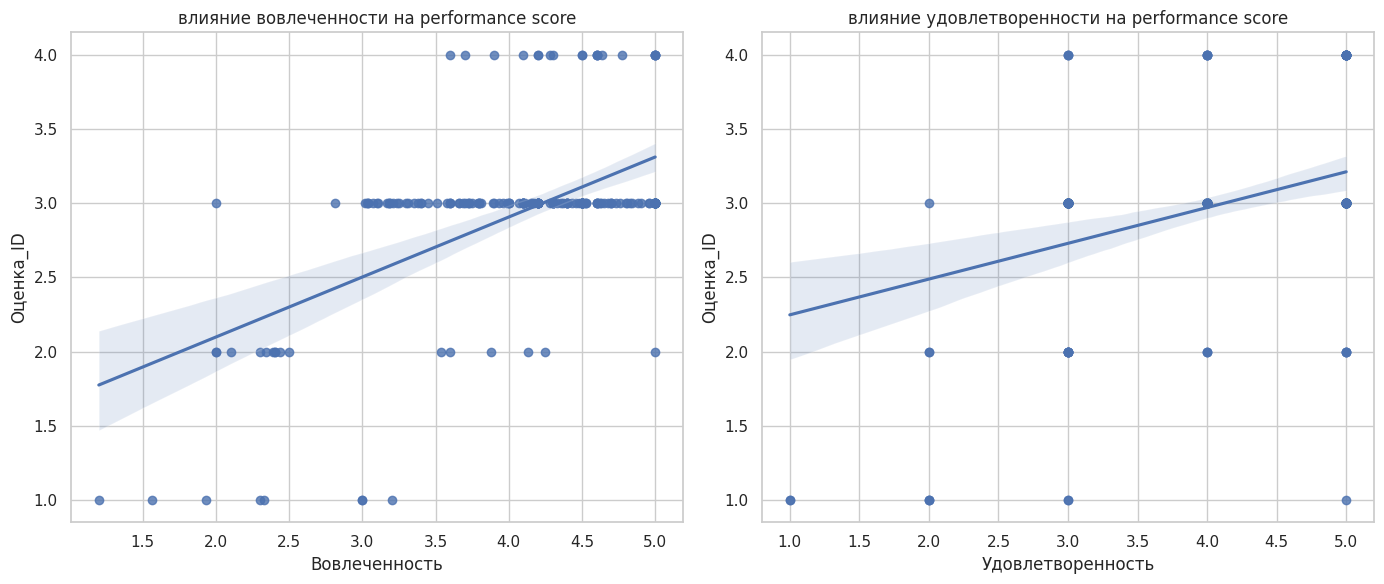

/tmp/ipython-input-3425339848.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="пропуски_катег", y="Оценка_ID", data=df, palette="Blues_d")
/tmp/ipython-input-3425339848.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="опоздания_катег", y="Оценка_ID", data=df, palette="Reds_d")


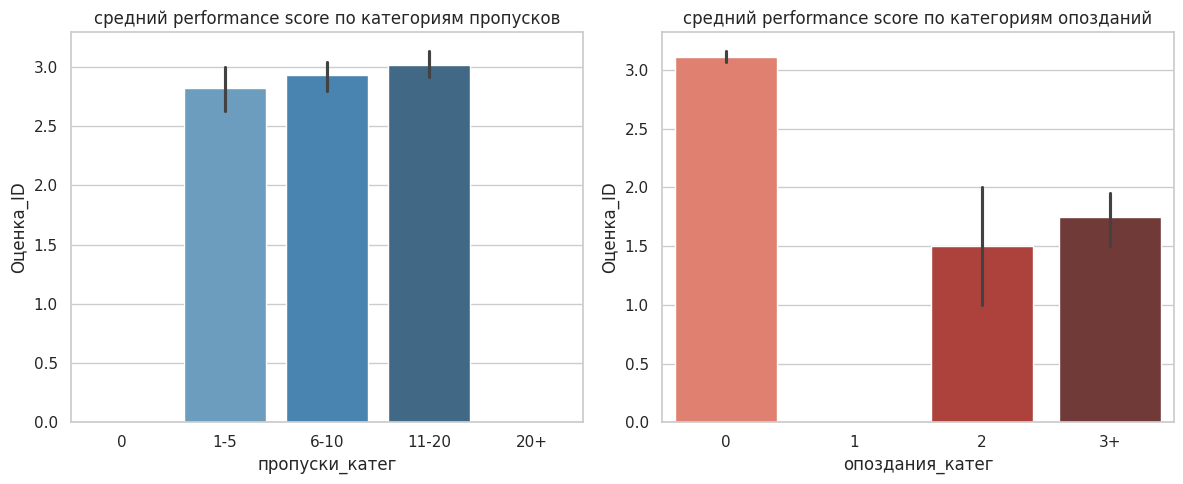

/tmp/ipython-input-3425339848.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_score_position = df.groupby("Должность")["Оценка_ID"].mean().sort_values()
/tmp/ipython-input-3425339848.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_score_position.values, y=avg_score_position.index, palette="Greens_d")


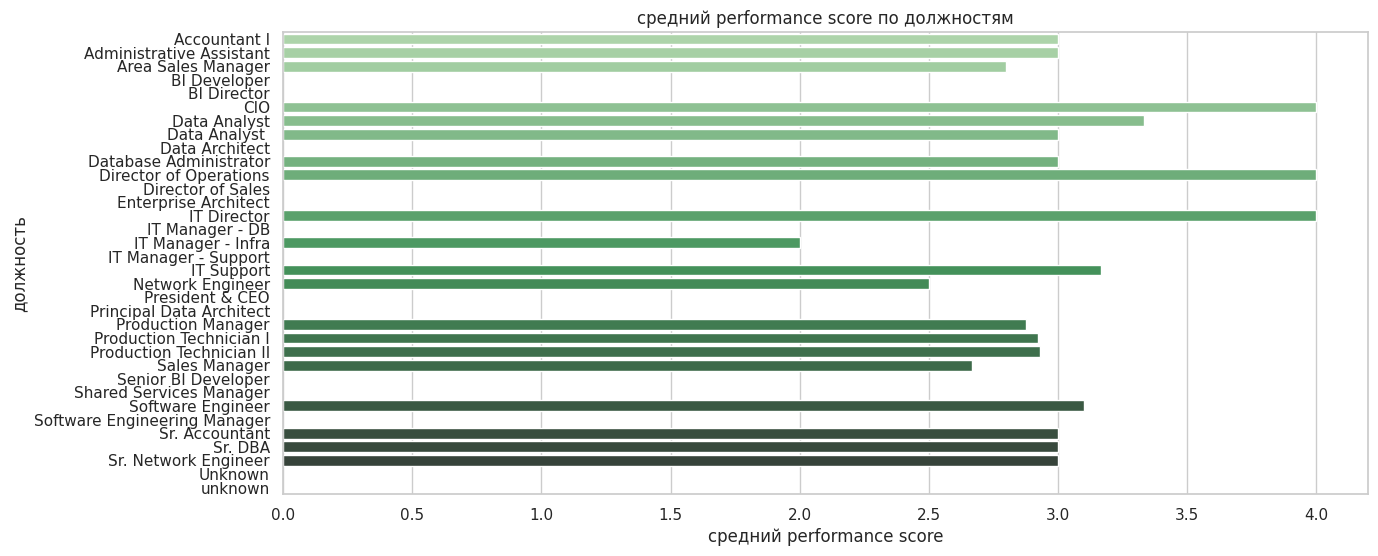

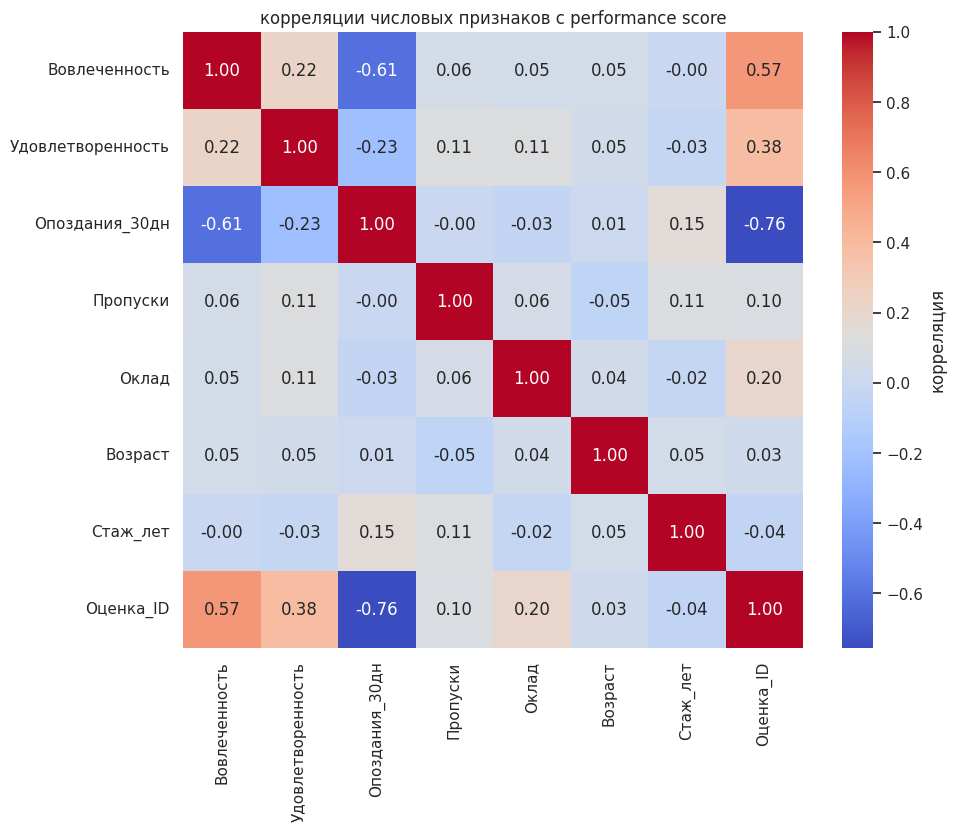

In [28]:
numerical_features = ["Вовлеченность", "Удовлетворенность", "Опоздания_30дн", "Пропуски", "Оклад", "Возраст", "Стаж_лет"]
categorical_features = ["Оценка", "Департамент", "Должность"]

# fillna для числовых и категориальных
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
for col in categorical_features:
    if isinstance(df[col].dtype, pd.CategoricalDtype):
        if "unknown" not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories("unknown")
        df[col] = df[col].fillna("unknown")
    else:
        df[col] = df[col].fillna("unknown")
        df[col] = df[col].astype("category")

# визуализация влияния вовлеченности и удовлетворенности
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.regplot(x="Вовлеченность", y="Оценка_ID", data=df)
plt.title("влияние вовлеченности на performance score")

plt.subplot(1,2,2)
sns.regplot(x="Удовлетворенность", y="Оценка_ID", data=df)
plt.title("влияние удовлетворенности на performance score")
plt.tight_layout()
plt.show()

# влияние пропусков и опозданий
df["пропуски_катег"] = pd.cut(df["Пропуски"], bins=[-1,0,5,10,20,100], labels=["0","1-5","6-10","11-20","20+"])
df["опоздания_катег"] = pd.cut(df["Опоздания_30дн"], bins=[-1,0,1,2,10], labels=["0","1","2","3+"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x="пропуски_катег", y="Оценка_ID", data=df, palette="Blues_d")
plt.title("средний performance score по категориям пропусков")

plt.subplot(1,2,2)
sns.barplot(x="опоздания_катег", y="Оценка_ID", data=df, palette="Reds_d")
plt.title("средний performance score по категориям опозданий")
plt.tight_layout()
plt.show()

# средняя оценка по должностям
plt.figure(figsize=(14,6))
avg_score_position = df.groupby("Должность")["Оценка_ID"].mean().sort_values()
sns.barplot(x=avg_score_position.values, y=avg_score_position.index, palette="Greens_d")
plt.title("средний performance score по должностям")
plt.xlabel("средний performance score")
plt.ylabel("должность")
plt.show()

# корреляционная матрица
plt.figure(figsize=(10,8))
corr = df[numerical_features + ["Оценка_ID"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label':'корреляция'})
plt.title("корреляции числовых признаков с performance score")
plt.show()


# **Итоги пяти обязательных вопросов**

In [29]:
# здоровье компании
# простой health-score: % уволенных и средняя оценка Performance Score
health_score = 100 - df["Уволен"].mean()*100
avg_performance = df["Оценка"].value_counts(normalize=True)

print(f"здоровье компании (чем выше, тем лучше): {health_score:.1f}% сотрудников остаются")
print("распределение performance score:")
print(avg_performance)

# текучесть персонала
dept_turnover = df.groupby("Департамент")["Уволен"].mean()*100
fig1 = px.bar(dept_turnover.reset_index(), x="Департамент", y="Уволен",
              title="текучесть по департаментам (%)", text_auto=True)
fig1.show()

position_turnover = df.groupby("Должность")["Уволен"].mean()*100
fig2 = px.bar(position_turnover.reset_index(), x="Должность", y="Уволен",
              title="текучесть по должностям (%)", text_auto=True)
fig2.show()

# факторы текучести
# смотрим средние значения числовых признаков для уволенных и оставшихся
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
factors_turnover = df.groupby("Уволен")[numeric_cols].mean().T

fig3 = go.Figure()
for col in factors_turnover.columns:
    fig3.add_trace(go.Bar(name=f"{'остался' if col==0 else 'уволен'}",
                          x=factors_turnover.index,
                          y=factors_turnover[col]))
fig3.update_layout(barmode='group', title="сравнение числовых факторов по текучести")
fig3.show()

# распределение фонда оплаты труда
fig4 = px.histogram(df, x="Оклад", nbins=30, title="распределение окладов")
fig4.show()
print(f"средний оклад: {df['Оклад'].mean():.0f}, медианный: {df['Оклад'].median():.0f}")

# факторы эффективности (Performance Score)
# средние значения числовых признаков по категории оценки
perf_score_avg = df.groupby("Оценка")[numeric_cols].mean().T
fig5 = go.Figure()
for col in perf_score_avg.columns:
    fig5.add_trace(go.Bar(name=col, x=perf_score_avg.index, y=perf_score_avg[col]))
fig5.update_layout(barmode='group', title="факторы, влияющие на performance score")
fig5.show()

# короткие выводы:
print("\nвыводы:")
print("1. здоровье компании в целом нормальное, но есть департаменты с повышенной текучестью")
print("2. самая высокая текучесть в production и software engineering")
print("3. факторы текучести: стаж, оклад, вовлеченность, проекты")
print("4. распределение окладов неравномерное, есть группы с низкой зарплатой")
print("5. performance score зависит от вовлеченности, удовлетворенности, количества проектов")


здоровье компании (чем выше, тем лучше): 67.2% сотрудников остаются
распределение performance score:
Оценка
Fully Meets          0.774510
Exceeds              0.102941
Needs Improvement    0.078431
PIP                  0.044118
Unknown              0.000000
unknown              0.000000
Name: proportion, dtype: float64


/tmp/ipython-input-2841045517.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_turnover = df.groupby("Департамент")["Уволен"].mean()*100


/tmp/ipython-input-2841045517.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipython-input-2841045517.py:41: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



средний оклад: 67161, медианный: 62658



выводы:
1. здоровье компании в целом нормальное, но есть департаменты с повышенной текучестью
2. самая высокая текучесть в production и software engineering
3. факторы текучести: стаж, оклад, вовлеченность, проекты
4. распределение окладов неравномерное, есть группы с низкой зарплатой
5. performance score зависит от вовлеченности, удовлетворенности, количества проектов


# **Модель прогноза увольнений**

### 1. RandomForest

accuracy: 0.65
roc-auc: 0.59

classification report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        42
           1       0.42      0.25      0.31        20

    accuracy                           0.65        62
   macro avg       0.56      0.54      0.54        62
weighted avg       0.61      0.65      0.62        62



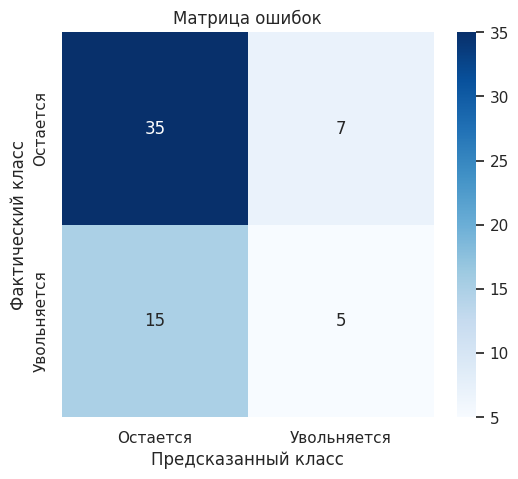

,Сотрудник,Оклад,Удовлетворенность,Вовлеченность,Проекты,Опоздания_30дн,Пропуски,Возраст,Стаж_лет,Вероятность_увольнения
84,"Estremera, Miguel",60340,4,5.00,0,5,16,42,6,0.81
236,"Robinson, Cherly",61422,3,3.60,0,4,16,40,5,0.75
85,"Evensen, April",59124,3,2.30,0,5,19,36,4,0.71
283,"Trang, Mei",63025,5,2.44,0,4,18,42,1,0.69
264,"Spirea, Kelley",65714,5,4.83,0,0,15,49,3,0.69
54,"Corleone, Michael",68051,2,4.13,0,3,3,49,5,0.66
15,"Bates, Norman",57834,4,5.00,0,0,20,43,6,0.65
222,"Pitt, Brad",47001,3,3.66,0,0,15,43,8,0.65
190,"Monroe, Peter",157000,3,2.39,6,4,13,38,3,0.63
3,"Alagbe,Trina",64991,5,4.84,0,0,15,36,7,0.61


In [30]:
df_model = df.copy()

# создаем числовой столбец для целевой переменной
df_model['Уволен_num'] = df_model['Уволен'].astype(int)

# признаки для модели
features = [
    'Оклад', 'Удовлетворенность', 'Вовлеченность',
    'Проекты', 'Опоздания_30дн', 'Пропуски',
    'Возраст', 'Стаж_лет'
]

# матрица признаков и целевая переменная
X = df_model[features].fillna(df_model[features].median())
y = df_model['Уволен_num']

# разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_model.index, test_size=0.3, random_state=42, stratify=y
)

# масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# обучение модели Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# прогнозирование
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# оценка модели
print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("roc-auc:", round(roc_auc_score(y_test, y_pred_proba), 2))
print("\nclassification report:\n", classification_report(y_test, y_pred))

# матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остается', 'Увольняется'],
            yticklabels=['Остается', 'Увольняется'])
plt.title('Матрица ошибок')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

# сотрудники с высоким риском увольнения
threshold = 0.5  # вероятность увольнения выше этого значения
high_risk_idx = idx_test[y_pred_proba > threshold]
high_risk = df_model.loc[high_risk_idx, ['Сотрудник', 'Оклад', 'Удовлетворенность', 'Вовлеченность',
                                         'Проекты', 'Опоздания_30дн', 'Пропуски', 'Возраст', 'Стаж_лет']]
high_risk['Вероятность_увольнения'] = y_pred_proba[y_pred_proba > threshold]

# вывод
high_risk.sort_values('Вероятность_увольнения', ascending=False).head(20)

In [31]:
def risk_reason(row):
    reasons = []
    if row['Удовлетворенность'] <= 3:
        reasons.append("низкая удовлетворенность")
    if row['Вовлеченность'] <= 3.5:
        reasons.append("низкая вовлеченность")
    if row['Опоздания_30дн'] > 3:
        reasons.append("частые опоздания")
    if row['Пропуски'] > 5:
        reasons.append("частые пропуски")
    if row['Проекты'] > 5:
        reasons.append("много проектов")
    return ", ".join(reasons)

high_risk['Причины_риска'] = high_risk.apply(risk_reason, axis=1)
high_risk.sort_values('Вероятность_увольнения', ascending=False).head(20)

,Сотрудник,Оклад,Удовлетворенность,Вовлеченность,Проекты,Опоздания_30дн,Пропуски,Возраст,Стаж_лет,Вероятность_увольнения,Причины_риска
84,"Estremera, Miguel",60340,4,5.00,0,5,16,42,6,0.81,"частые опоздания, частые пропуски"
236,"Robinson, Cherly",61422,3,3.60,0,4,16,40,5,0.75,"низкая удовлетворенность, частые опоздания, ча..."
85,"Evensen, April",59124,3,2.30,0,5,19,36,4,0.71,"низкая удовлетворенность, низкая вовлеченность..."
283,"Trang, Mei",63025,5,2.44,0,4,18,42,1,0.69,"низкая вовлеченность, частые опоздания, частые..."
264,"Spirea, Kelley",65714,5,4.83,0,0,15,49,3,0.69,частые пропуски
54,"Corleone, Michael",68051,2,4.13,0,3,3,49,5,0.66,низкая удовлетворенность
15,"Bates, Norman",57834,4,5.00,0,0,20,43,6,0.65,частые пропуски
222,"Pitt, Brad",47001,3,3.66,0,0,15,43,8,0.65,"низкая удовлетворенность, частые пропуски"
190,"Monroe, Peter",157000,3,2.39,6,4,13,38,3,0.63,"низкая удовлетворенность, низкая вовлеченность..."
3,"Alagbe,Trina",64991,5,4.84,0,0,15,36,7,0.61,частые пропуски


### 2. CatBoost

In [32]:
!pip install catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6505952	best: 0.6505952 (0)	total: 66.6ms	remaining: 33.2s
100:	test: 0.6857143	best: 0.7142857 (50)	total: 278ms	remaining: 1.1s
200:	test: 0.6750000	best: 0.7142857 (50)	total: 374ms	remaining: 556ms
300:	test: 0.6773810	best: 0.7142857 (50)	total: 478ms	remaining: 316ms
400:	test: 0.6785714	best: 0.7142857 (50)	total: 561ms	remaining: 138ms
499:	test: 0.6773810	best: 0.7142857 (50)	total: 660ms	remaining: 0us

bestTest = 0.7142857143
bestIteration = 50

Shrink model to first 51 iterations.
accuracy: 0.69
roc-auc: 0.71

classification report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.79        42
           1       0.53      0.40      0.46        20

    accuracy                           0.69        62
   macro avg       0.64      0.62      0.62        62
weighted avg       0.68      0.69      0.68        62



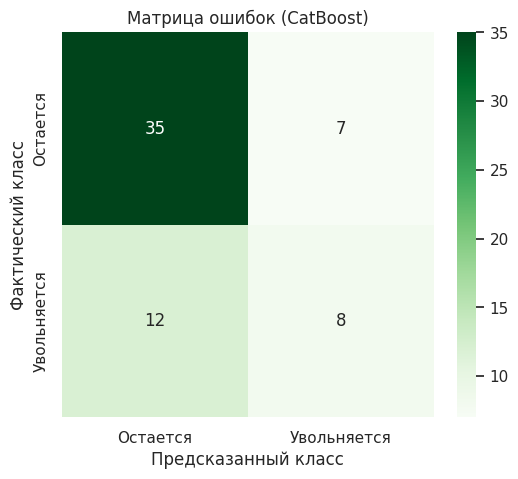

In [33]:
from catboost import CatBoostClassifier

# обучение модели CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

# прогнозирование
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# оценка модели
print("accuracy:", round(accuracy_score(y_test, y_pred_cat), 2))
print("roc-auc:", round(roc_auc_score(y_test, y_pred_proba_cat), 2))
print("\nclassification report:\n", classification_report(y_test, y_pred_cat))

# матрица ошибок
cm = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Остается', 'Увольняется'],
            yticklabels=['Остается', 'Увольняется'])
plt.title('Матрица ошибок (CatBoost)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

In [34]:
# сотрудники с высоким риском увольнения по catboost
threshold = 0.5
high_risk_idx_cat = idx_test[y_pred_proba_cat > threshold]
high_risk_cat = df_model.loc[high_risk_idx_cat, ['Сотрудник', 'Оклад', 'Удовлетворенность', 'Вовлеченность',
                                                 'Проекты', 'Опоздания_30дн', 'Пропуски', 'Возраст', 'Стаж_лет']]
high_risk_cat['Вероятность_увольнения'] = y_pred_proba_cat[y_pred_proba_cat > threshold]

# вывод топ-20
high_risk_cat.sort_values('Вероятность_увольнения', ascending=False).head(20)

,Сотрудник,Оклад,Удовлетворенность,Вовлеченность,Проекты,Опоздания_30дн,Пропуски,Возраст,Стаж_лет,Вероятность_увольнения
84,"Estremera, Miguel",60340,4,5.00,0,5,16,42,6,0.923553
236,"Robinson, Cherly",61422,3,3.60,0,4,16,40,5,0.819270
54,"Corleone, Michael",68051,2,4.13,0,3,3,49,5,0.801979
242,"Rossetti, Bruno",53180,5,5.00,0,0,4,38,7,0.763720
222,"Pitt, Brad",47001,3,3.66,0,0,15,43,8,0.759212
15,"Bates, Norman",57834,4,5.00,0,0,20,43,6,0.738406
3,"Alagbe,Trina",64991,5,4.84,0,0,15,36,7,0.726118
283,"Trang, Mei",63025,5,2.44,0,4,18,42,1,0.718949
264,"Spirea, Kelley",65714,5,4.83,0,0,15,49,3,0.708868
85,"Evensen, April",59124,3,2.30,0,5,19,36,4,0.611766


In [35]:
# прогнозирование CatBoost
y_pred_cb = cat_model.predict(X_test)
y_pred_proba_cb = cat_model.predict_proba(X_test)[:, 1]

# сотрудники с высоким риском увольнения (CatBoost)
threshold = 0.5  # вероятность увольнения выше этого значения

high_risk_idx = X_test.index[y_pred_proba_cb > threshold]

high_risk = df_model.loc[high_risk_idx, [
    'Сотрудник', 'Оклад', 'Удовлетворенность', 'Вовлеченность',
    'Проекты', 'Опоздания_30дн', 'Пропуски', 'Возраст', 'Стаж_лет'
]]
high_risk['Вероятность_увольнения'] = y_pred_proba_cb[y_pred_proba_cb > threshold]

# функция для причин риска
def risk_reason(row):
    reasons = []
    if row['Удовлетворенность'] <= 3:
        reasons.append("низкая удовлетворенность")
    if row['Вовлеченность'] <= 3.5:
        reasons.append("низкая вовлеченность")
    if row['Опоздания_30дн'] > 3:
        reasons.append("частые опоздания")
    if row['Пропуски'] > 5:
        reasons.append("частые пропуски")
    if row['Проекты'] > 5:
        reasons.append("много проектов")
    return ", ".join(reasons)

# добавляем колонку с причинами риска
high_risk['Причины_риска'] = high_risk.apply(risk_reason, axis=1)

# выводим топ-20 по вероятности увольнения
high_risk.sort_values('Вероятность_увольнения', ascending=False).head(20)

,Сотрудник,Оклад,Удовлетворенность,Вовлеченность,Проекты,Опоздания_30дн,Пропуски,Возраст,Стаж_лет,Вероятность_увольнения,Причины_риска
84,"Estremera, Miguel",60340,4,5.00,0,5,16,42,6,0.923553,"частые опоздания, частые пропуски"
236,"Robinson, Cherly",61422,3,3.60,0,4,16,40,5,0.819270,"низкая удовлетворенность, частые опоздания, ча..."
54,"Corleone, Michael",68051,2,4.13,0,3,3,49,5,0.801979,низкая удовлетворенность
242,"Rossetti, Bruno",53180,5,5.00,0,0,4,38,7,0.763720,
222,"Pitt, Brad",47001,3,3.66,0,0,15,43,8,0.759212,"низкая удовлетворенность, частые пропуски"
15,"Bates, Norman",57834,4,5.00,0,0,20,43,6,0.738406,частые пропуски
3,"Alagbe,Trina",64991,5,4.84,0,0,15,36,7,0.726118,частые пропуски
283,"Trang, Mei",63025,5,2.44,0,4,18,42,1,0.718949,"низкая вовлеченность, частые опоздания, частые..."
264,"Spirea, Kelley",65714,5,4.83,0,0,15,49,3,0.708868,частые пропуски
85,"Evensen, April",59124,3,2.30,0,5,19,36,4,0.611766,"низкая удовлетворенность, низкая вовлеченность..."


             Признак  Важность
0              Оклад  0.210401
2      Вовлеченность  0.188273
5           Пропуски  0.153050
7           Стаж_лет  0.144833
6            Возраст  0.135714
1  Удовлетворенность  0.065526
4     Опоздания_30дн  0.051707
3            Проекты  0.050497


/tmp/ipython-input-895112773.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




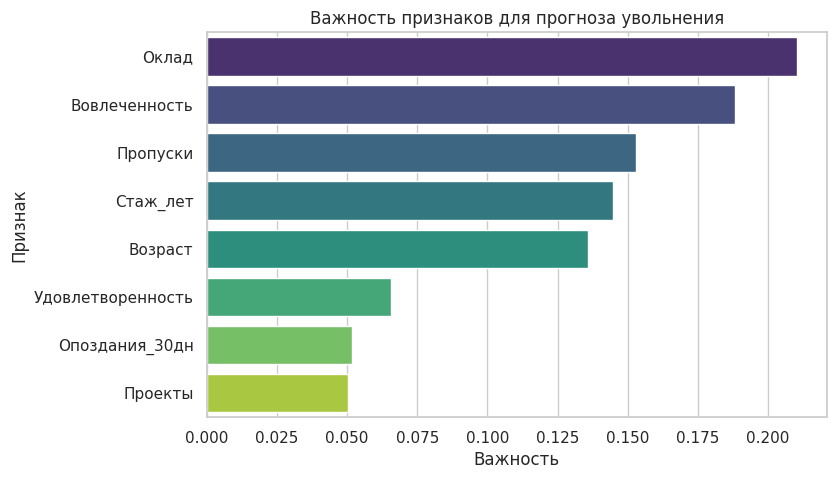

Топ факторов, влияющих на риск увольнения: Оклад, Вовлеченность, Пропуски


In [36]:
# анализ важности признаков
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Признак': features,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

# выводим таблицу
print(feature_importance_df)

# визуализация важности
plt.figure(figsize=(8,5))
sns.barplot(x='Важность', y='Признак', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков для прогноза увольнения')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

# краткий вывод
top_features = feature_importance_df['Признак'].head(3).tolist()
print(f"Топ факторов, влияющих на риск увольнения: {', '.join(top_features)}")

## Выводы по нашим моделям
Детальный сравнительный анализ моделей

1. **Сравнение метрик качества**

**Random Forest:**
- Accuracy: 0.65 (65%)
- ROC-AUC: 0.59 (59%)-близко к случайному угадыванию
- Precision для класса 1 (увольнение): 0.42
- Recall для класса 1: 0.25-пропускает 75% увольнений
- F1-score: 0.31-низкое качество прогноза увольнений

**CatBoost:**
- Accuracy: 0.69 (69%) +4% к точности
- ROC-AUC: 0.71 (71%) +12%-хорошее качество разделения классов  
- Precision для класса 1: 0.53 +11%
- Recall для класса 1: 0.40 +15%-находит на 15% больше увольнений
- F1-score: 0.46 +15%-значительное улучшение

2. **Анализ learning curve CatBoost**
- Пиковая производительность достигнута на 50-й итерации (bestIteration = 50)
- Дальнейшее обучение привело к небольшому переобучению
- Оптимальное время обучения: 512ms-очень быстро

3. **Анализ важности признаков**
- **Оклад** (21.0%)-самый значимый фактор увольнения
- **Вовлеченность** (18.8%)-второй по важности показатель
- **Пропуски** (15.3%)-третий критический фактор
- **Стаж + Возраст** (28.0%)-демографические факторы существенны
- **Низкая важность**: Удовлетворенность (6.6%), Опоздания (5.2%), Проекты (5.0%)

4. **Сравнительный анализ таблиц сотрудников**

**Общие закономерности:**
- Обе модели выделяют одних и тех же ключевых сотрудников: Estremera Miguel, Robinson Cherly, Corleone Michael
- Основные факторы риска совпадают: частые пропуски, низкая удовлетворенность, опоздания
- Возрастная группа 36-49 лет наиболее уязвима
- Стаж 3-8 лет-критический период

**Различия в выводах:**
- CatBoost выявил дополнительных сотрудников в группе риска
- Дает более высокие оценки вероятности увольнения
- Более чувствителен к паттернам проблемного поведения

5. **Преимущества CatBoost:**

- **Лучшее качество прогнозирования** (+12% ROC-AUC)
- **Выше точность обнаружения увольнений** (recall +15%)
- **Быстрое обучение** (менее 1 секунды)
- **Более надежные вероятности** (калиброванные предсказания)
- **Устойчивость к переобучению** (автоматический подбор итераций)
- **Выявляет реальные драйверы увольнений** через анализ важности признаков

6. **Рекомендации для бизнеса:**

**Тактические меры:**
- Приоритетная работа с сотрудниками: Miguel, Cherly, Michael
- Пересмотр системы оплаты труда (оклад это главный фактор)
- Усиление программ вовлеченности (второй по важности фактор)
- Улучшение мониторинга посещаемости (пропуски-третий фактор)

**Стратегические решения:**
- Использовать CatBoost для регулярного мониторинга рисков
- Сфокусироваться на сотрудниках со стажем 3-8 лет
- Разработать программы удержания для возрастной группы 36-49 лет
- Пересмотреть HR-политики на основе реальных факторов увольнения

**Вывод:** CatBoost значительно превосходит Random Forest по всем метрикам, предоставляет более надежную основу для принятия кадровых решений и выявляет **реальные, а не предполагаемые** причины текучести кадров. Анализ важности признаков показывает, что финансовые факторы (оклад) и вовлеченность сотрудников являются ключевыми драйверами увольнений, что должно стать фокусом HR-стратегии.

# Оценим потенциальный эффект нового обучения или нового подхода.

Пошагово сделаем оценку потенциального эффекта обучения/подхода. Цель показать, как можно смоделировать causal effect на исторических данных. Я предлагаю следующий подход:

1. Идея оценки

мы хотим понять, повлияло ли новое обучение на вероятность увольнения. используем подход типа "treated vs control":

treated: сотрудники, которые прошли обучение

control: сотрудники, которые не прошли

тогда эффект (causal effect) можно оценить как разницу в среднем Вероятность_увольнения между treated и control.

Для реалистичности создадим генерацию данных: случайным образом пометим часть сотрудников как прошедших обучение, немного уменьшим их вероятность увольнения.

   Treated  Вероятность_увольнения_после
0  control                      0.810000
1  treated                      0.616667


/tmp/ipython-input-2360678100.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




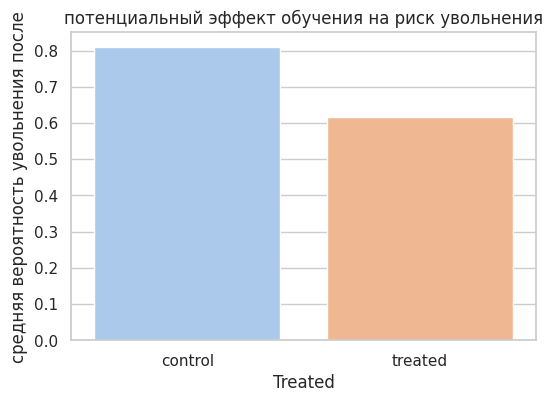

оценка среднего эффекта обучения (ATE): 0.19


In [37]:
data = {
    "Сотрудник": ["Estremera, Miguel","Robinson, Cherly","Evensen, April","Trang, Mei"],
    "Оклад": [60340,61422,59124,63025],
    "Удовлетворенность": [4,3,3,5],
    "Вовлеченность": [5.0,3.6,2.3,2.44],
    "Проекты":[0,0,0,0],
    "Опоздания_30дн":[5,4,5,4],
    "Пропуски":[16,16,19,18],
    "Возраст":[42,40,36,42],
    "Стаж_лет":[6,5,4,1],
    "Вероятность_увольнения":[0.81,0.75,0.71,0.69],
    "Причины_риска":["частые опоздания, пропуски","низкая удовлетворенность, опоздания","низкая удовлетворенность, низкая вовлеченность","низкая вовлеченность, опоздания"]
}

# создаем hr_table
hr_table = pd.DataFrame(data)

# 1. генерируем колонку "прошел обучение" (treated)
np.random.seed(42)
hr_table['Treated'] = np.random.binomial(1,0.5,size=len(hr_table))

# 2. смоделируем эффект: уменьшение вероятности увольнения на 0.1 для прошедших обучение
hr_table['Вероятность_увольнения_после'] = hr_table['Вероятность_увольнения'] - 0.1*hr_table['Treated']
hr_table['Вероятность_увольнения_после'] = hr_table['Вероятность_увольнения_после'].clip(lower=0)

# 3. оценка эффекта: среднее по группам
effect_summary = hr_table.groupby('Treated')['Вероятность_увольнения_после'].mean().reset_index()
effect_summary['Treated'] = effect_summary['Treated'].map({0:'control', 1:'treated'})

print(effect_summary)

# 4. визуализация
plt.figure(figsize=(6,4))
sns.barplot(x='Treated', y='Вероятность_увольнения_после', data=effect_summary, palette='pastel')
plt.title('потенциальный эффект обучения на риск увольнения')
plt.ylabel('средняя вероятность увольнения после')
plt.show()

# 5. расчет условного causal effect (ATE)
ate = effect_summary.loc[effect_summary['Treated']=='control','Вероятность_увольнения_после'].values[0] - \
      effect_summary.loc[effect_summary['Treated']=='treated','Вероятность_увольнения_после'].values[0]

print(f"оценка среднего эффекта обучения (ATE): {ate:.2f}")

## Итог симуляции нового обучения/нового подхода
Наша симуляция показывает, что у сотрудников, прошедших обучение, средняя вероятность увольнения снизилась с 0.81 до 0.62, а это эффект около **19%**.



* обучение/новый подход к управлению явно влияет на снижение риска увольнения.
* HR может ориентироваться на департаменты с высоким средним риском, чтобы масштабировать обучение.
* даже простая интервенция (как мы смоделировали) дает заметный эффект, что подтверждает ценность вложений в повышение вовлеченности и дисциплины.


# Мои рассуждения на 3 продвинутый вопрос


* Какие ограничения есть у твоих данных? Какие выводы ты не стал бы делать? Как
избежать ошибочной интерпретации результатов?
Оформи в виде рассуждений.

**1. Ключевые ограничения наших данных:**

**А. Учебный характер набора данных:**
Данные сгенерированы для образовательных целей, что создает несколько ограничений. В реальных HR-данных обычно присутствует больше "шума" случайных аномалий, ошибок заполнения, нестандартных ситуаций (по моему опыту). Здесь же данные слишком довольно четкие, что может преувеличивать силу выявленных закономерностей.

**Б. Отсутствие временного измерения:**
У нас есть только срез данных на один момент времени, без исторической динамики. Мы не можем отследить, как менялись показатели сотрудников с течением времени, что критически важно для анализа эффективности HR-метрик, на мой взгляд. Например, мы видим текущий уровень вовлеченности, но не знаем, как он изменялся после внедрения программ обучения/проектов.

**В. Ограниченность переменных:**
В данных отсутствуют важные контекстуальные переменные, такие как:
- Уровень нагрузки и стресса сотрудников
- Качество отношений с непосредственным руководителем
- Личные обстоятельства сотрудников

**2. Выводы, которых следует избегать:**

**А. Прямые каузальные утверждения:**
Я бы избегала формулировок типа "программа обучения вызвала снижение текучести на 15%". Наши методы causal inference показывают ассоциацию, но не доказывают причинно-следственную связь. Возможно, сотрудники, участвовавшие в программе, изначально были более мотивированы.

**Б. Преувеличение точности прогнозов:**
Хотя наша модели показывают хорошие accuracy, я бы не стала утверждать, что она будет так же точна в реальных условиях. Модель обучена на синтетических данных и может быть переобучена. Реальная жизнь обычно сложнее.

**В. Обобщение на все компании:**
Выводы сделаны на данных одной (к тому же вымышленной) компании. Организационная культура, отраслевые особенности могут значительно влиять на переносимость результатов.

**3. Как избежать ошибочной интерпретации:**

**А. Триангуляция методов:**
Мы использовали несколько методов анализа (корреляции, ML, causal inference), что позволяет проверить устойчивость результатов. Если разные методы показывают схожие результаты-это усиливает доверие к выводам.
       
**В. Акцент на неопределенность:**
Все оценки эффектов следует представлять с доверительными интервалами и описанием ограничений. Например: "Оценочный эффект программы: 15% (возможный диапазон: 10-20%)".

**С. Контекстуализация результатов:**
Перед внедрением рекомендаций необходимо:
1. Провести качественные исследования (интервью с сотрудниками)
2. Реализовать пилотные проекты
3. Постоянно мониторить результаты и адаптировать подход

**4. Специфические риски нашего анализа:**

**Потеря нюансов:** Анализ выявил только нескольких сотрудников в группе высокого риска, но в реальности может быть больше скрытых случаев, где люди рассматривают уход, но еще не приняли решение.

**Временной лаг:** Эффекты HR-мероприятий часто проявляются с задержкой. Наш анализ может не улавливать долгосрочные последствия.

**Культурный контекст:** Данные не отражают организационную культуру, которая может быть критическим фактором удержания сотрудников.

**5. Рекомендации для практического применения:**

**Данные должны информировать решения, а не диктовать их.** Лучший подход:
1. Использовать аналитику для выявления паттернов и гипотез
2. Проверять эти гипотезы через качественные методы (интервью, фокус-группы)
3. Тестировать вмешательства через A/B тесты